In [14]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd

model = Model(starttime=0.0, stoptime=120.0, dt=1.0, name="R3_loop")

# -----------------------------
# Stocks
# -----------------------------
households_connected = model.stock("households_connected")
households_not_connected = model.stock("households_not_connected")
indoor_pm25_concentration = model.stock("indoor_pm25_concentration")
outdoor_pm25_concentration = model.stock("outdoor_pm25_concentration")




0.00013823664740273263 0.00013820833333333334
8.027980831830761e-06 8e-06
2.0


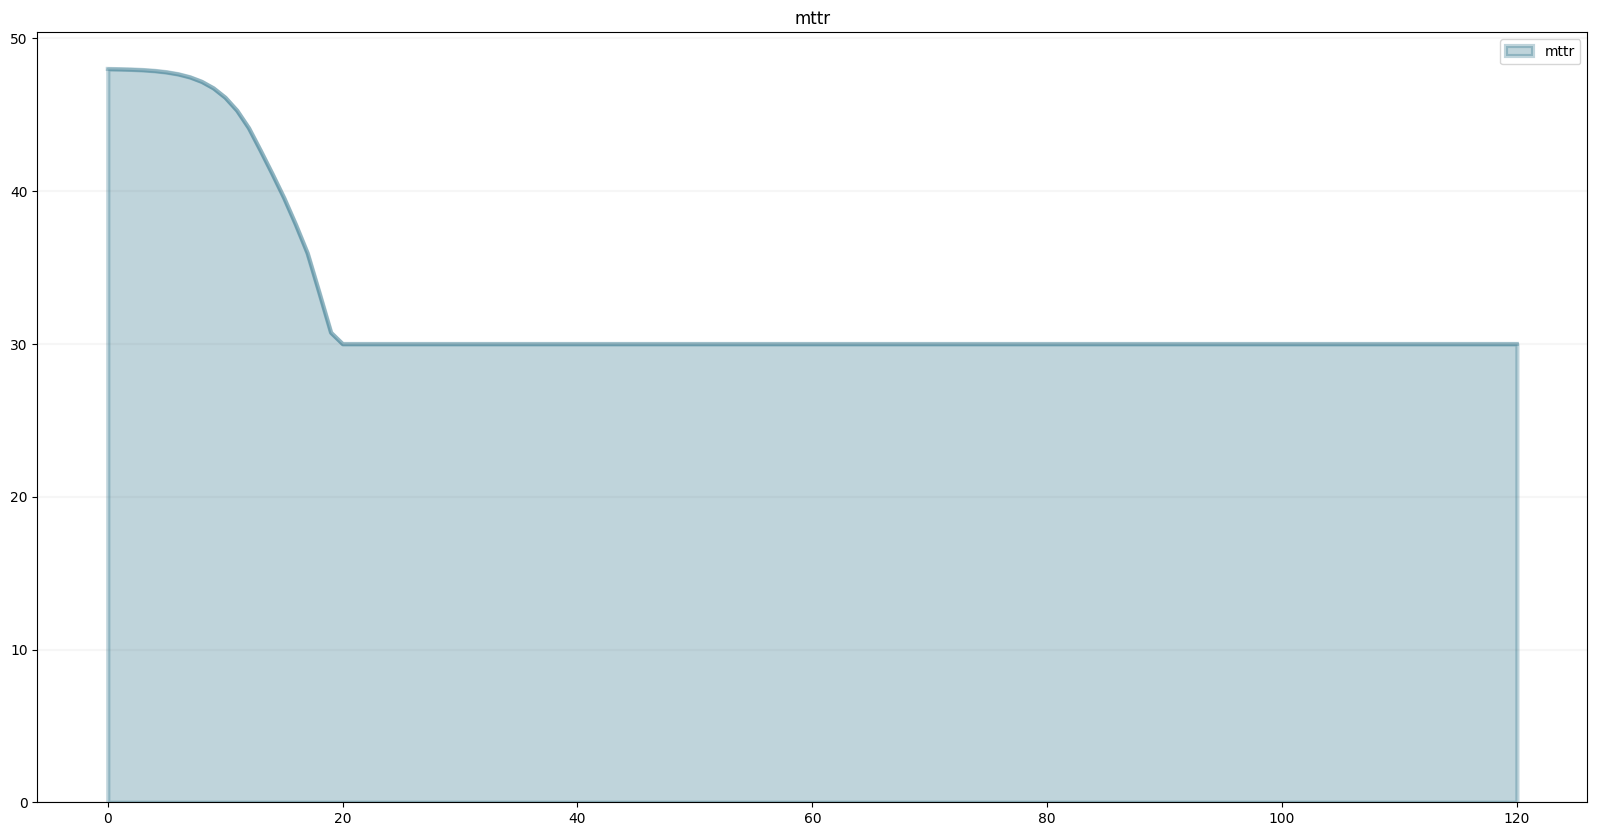

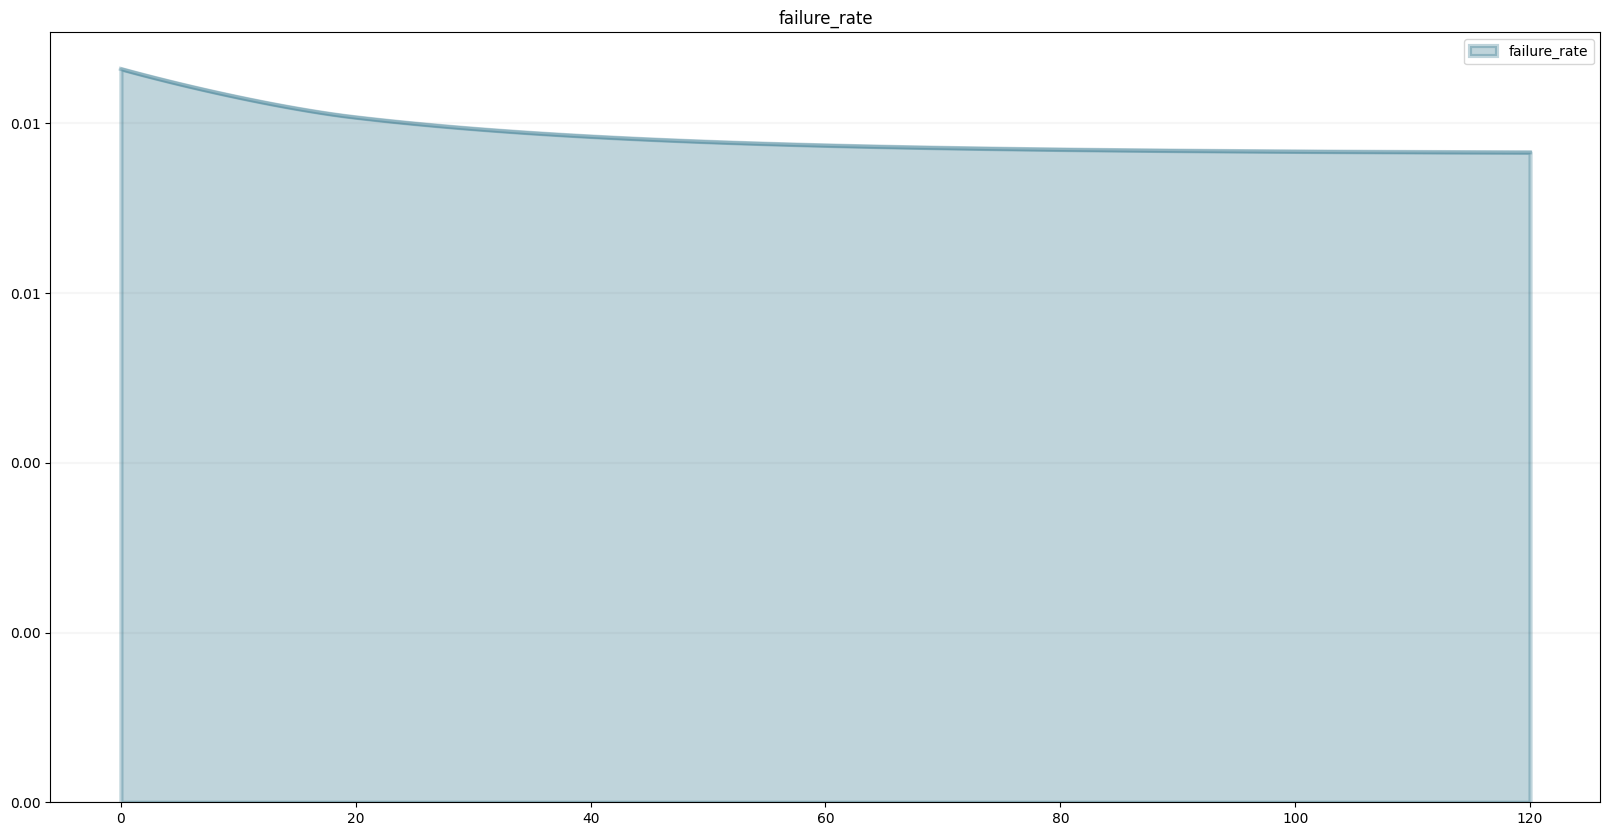

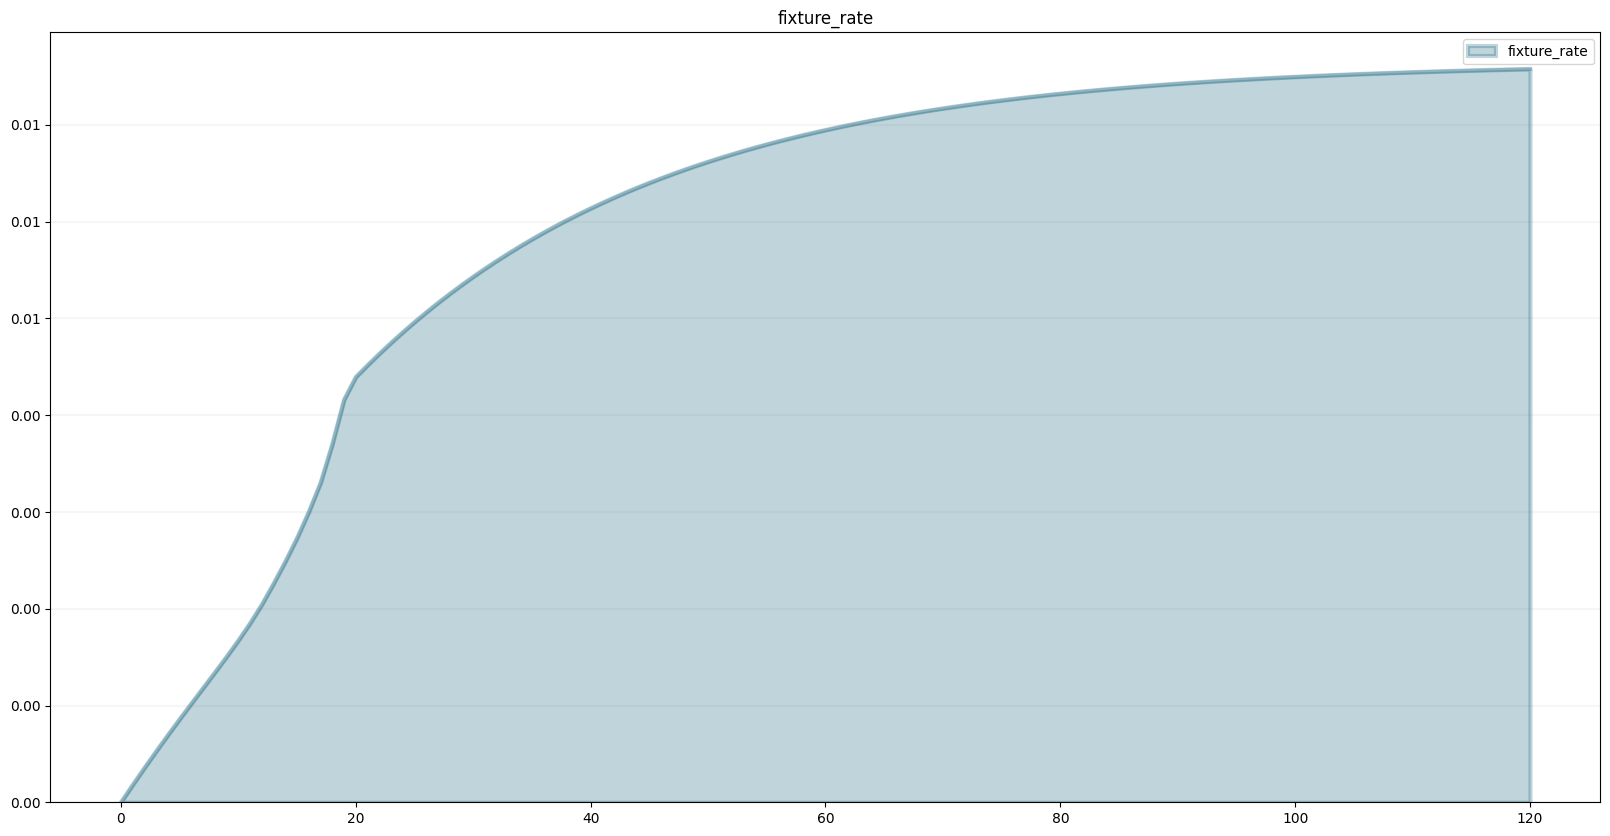

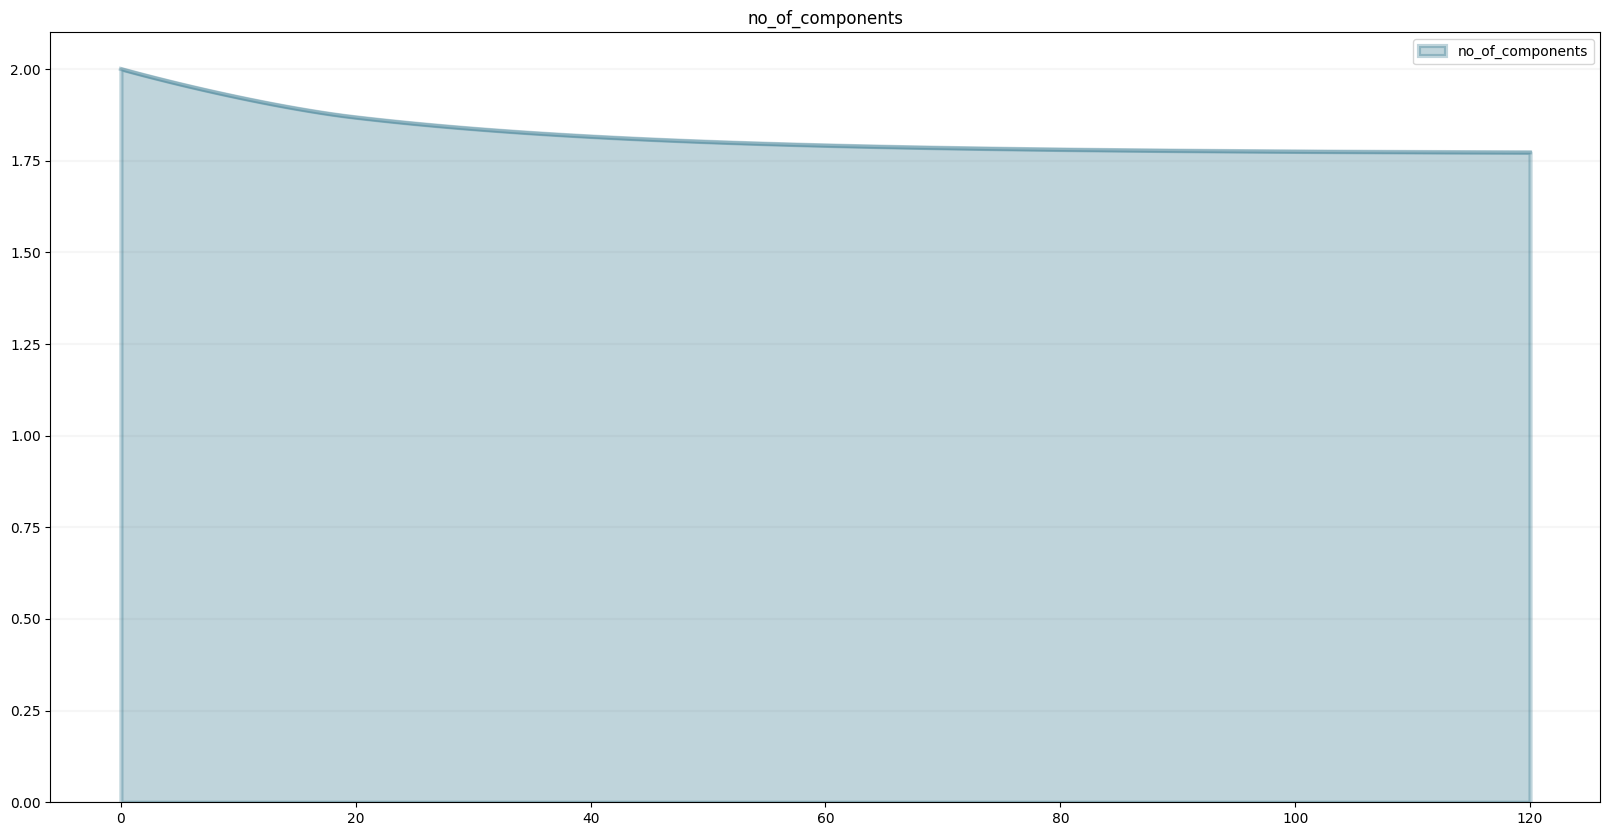

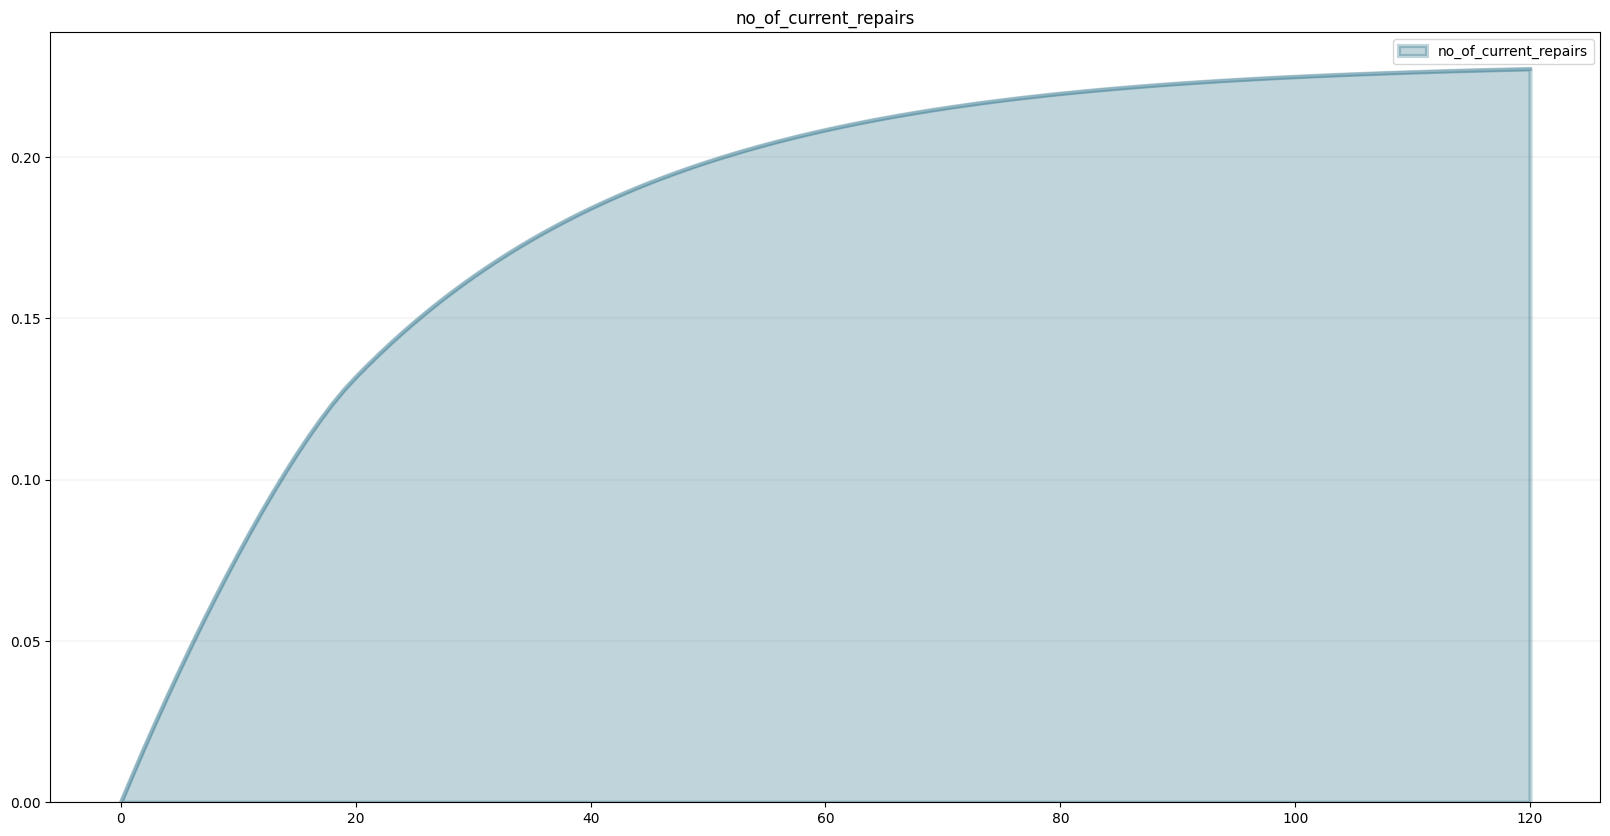

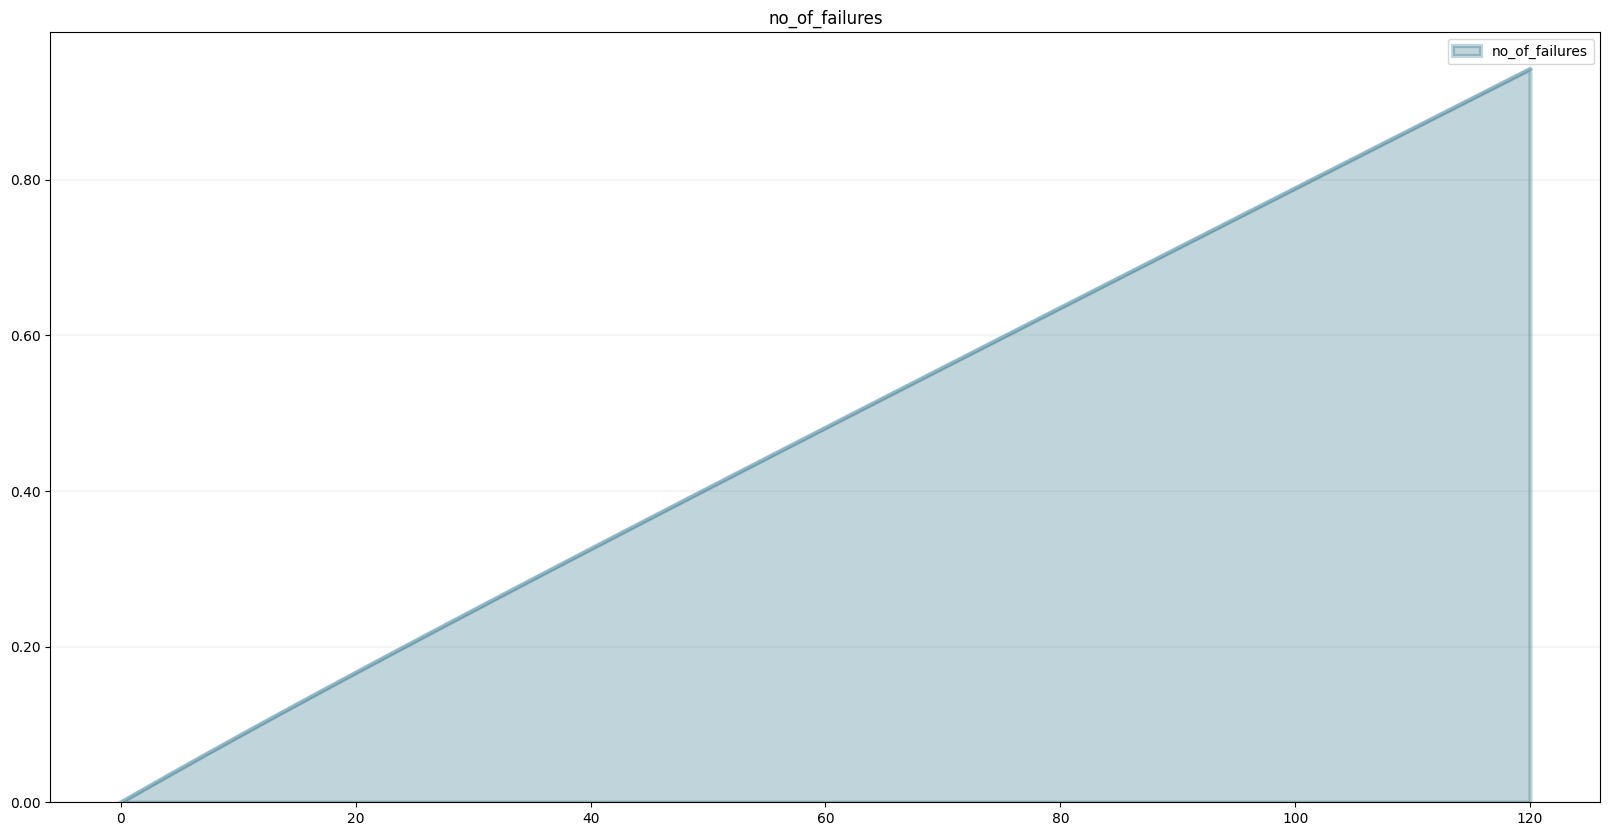

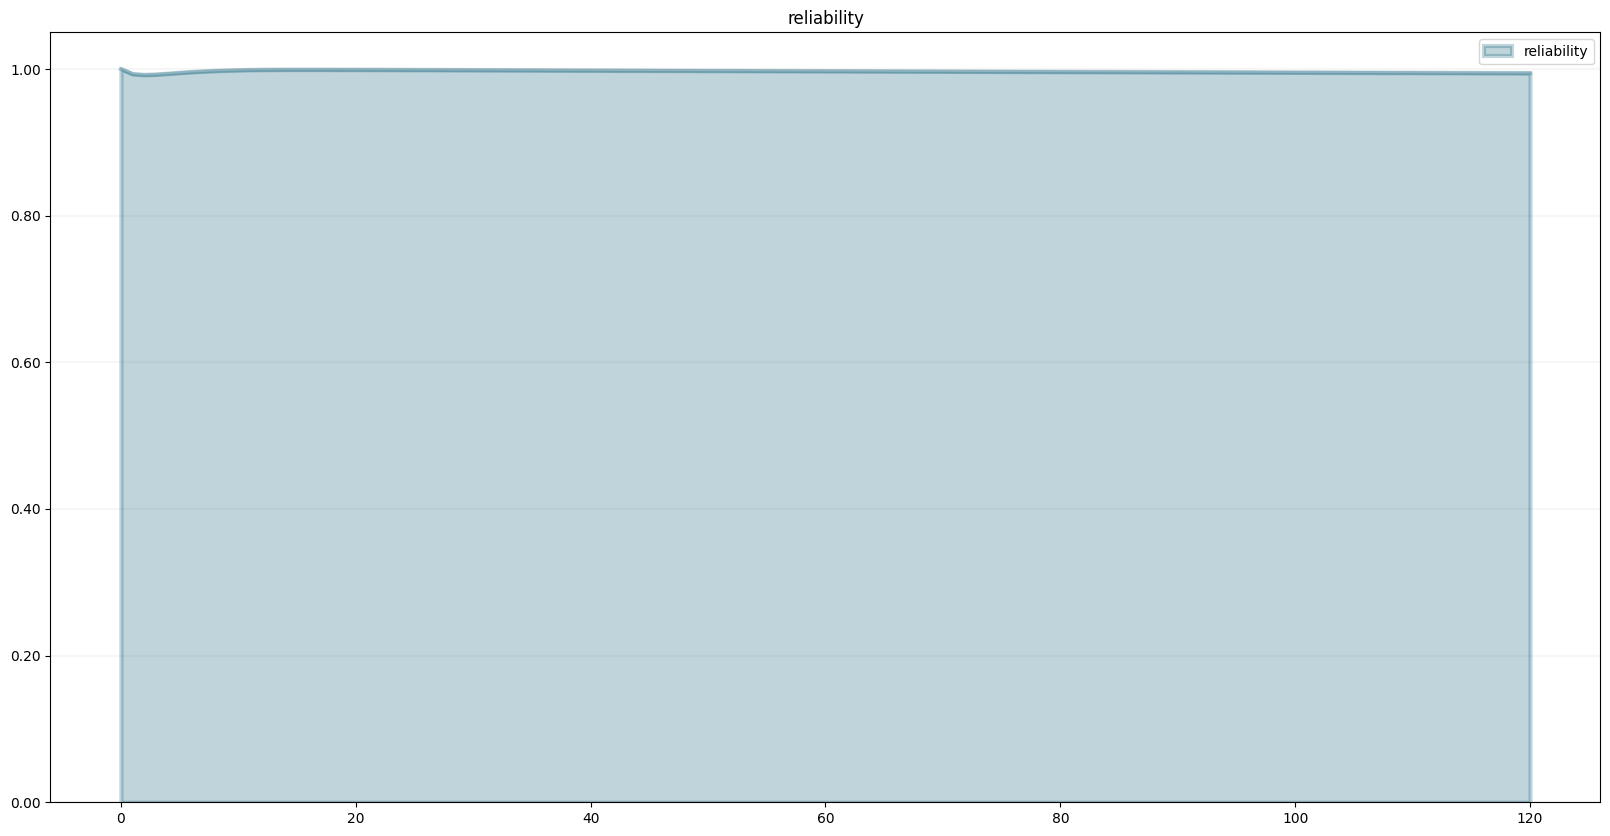

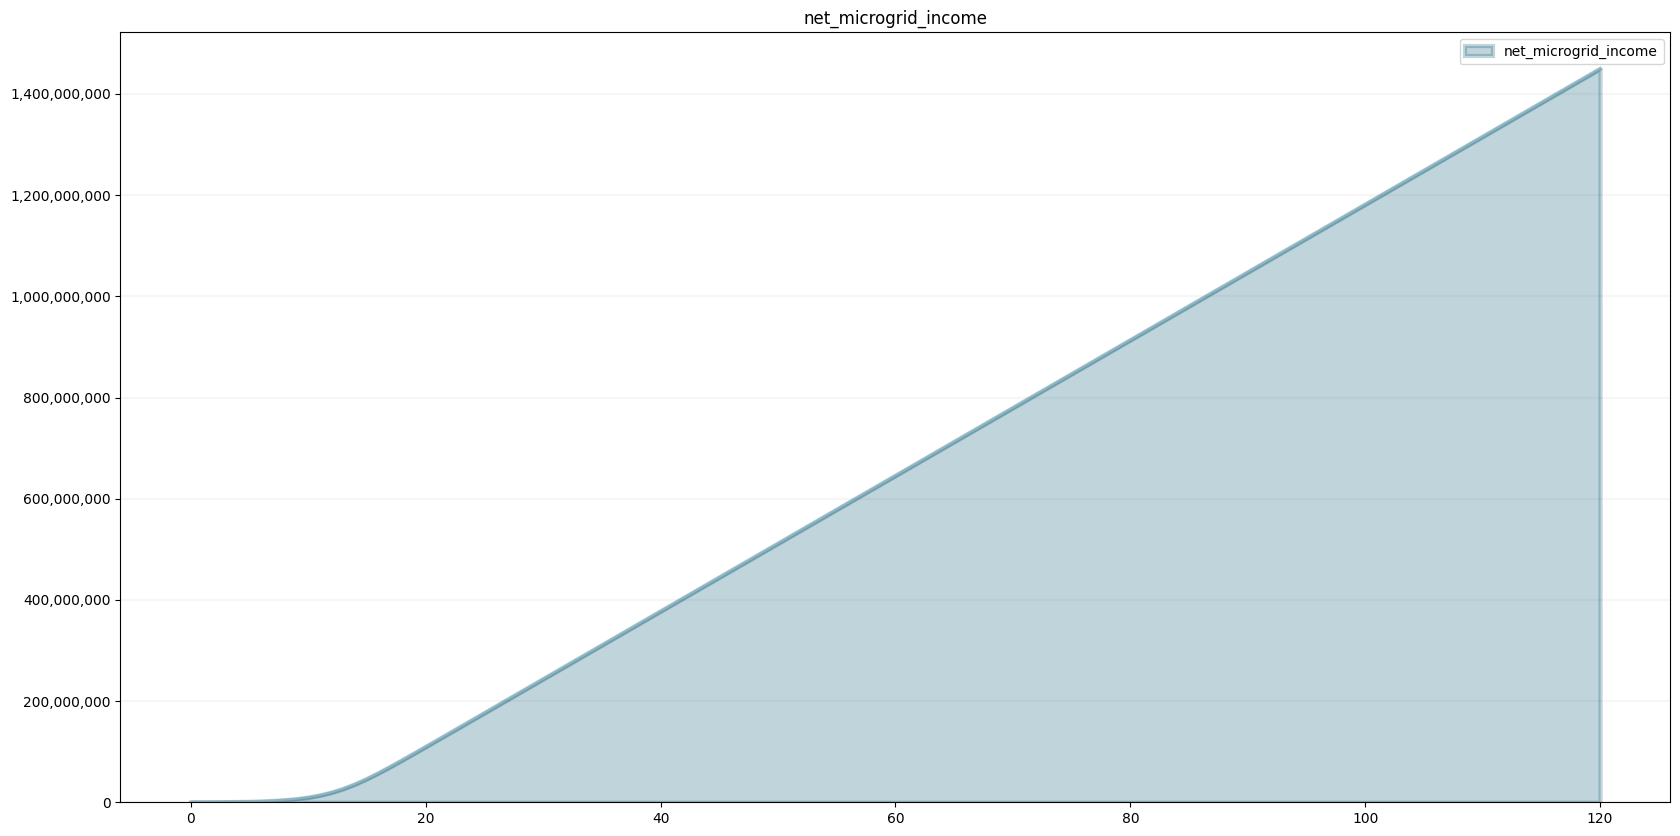

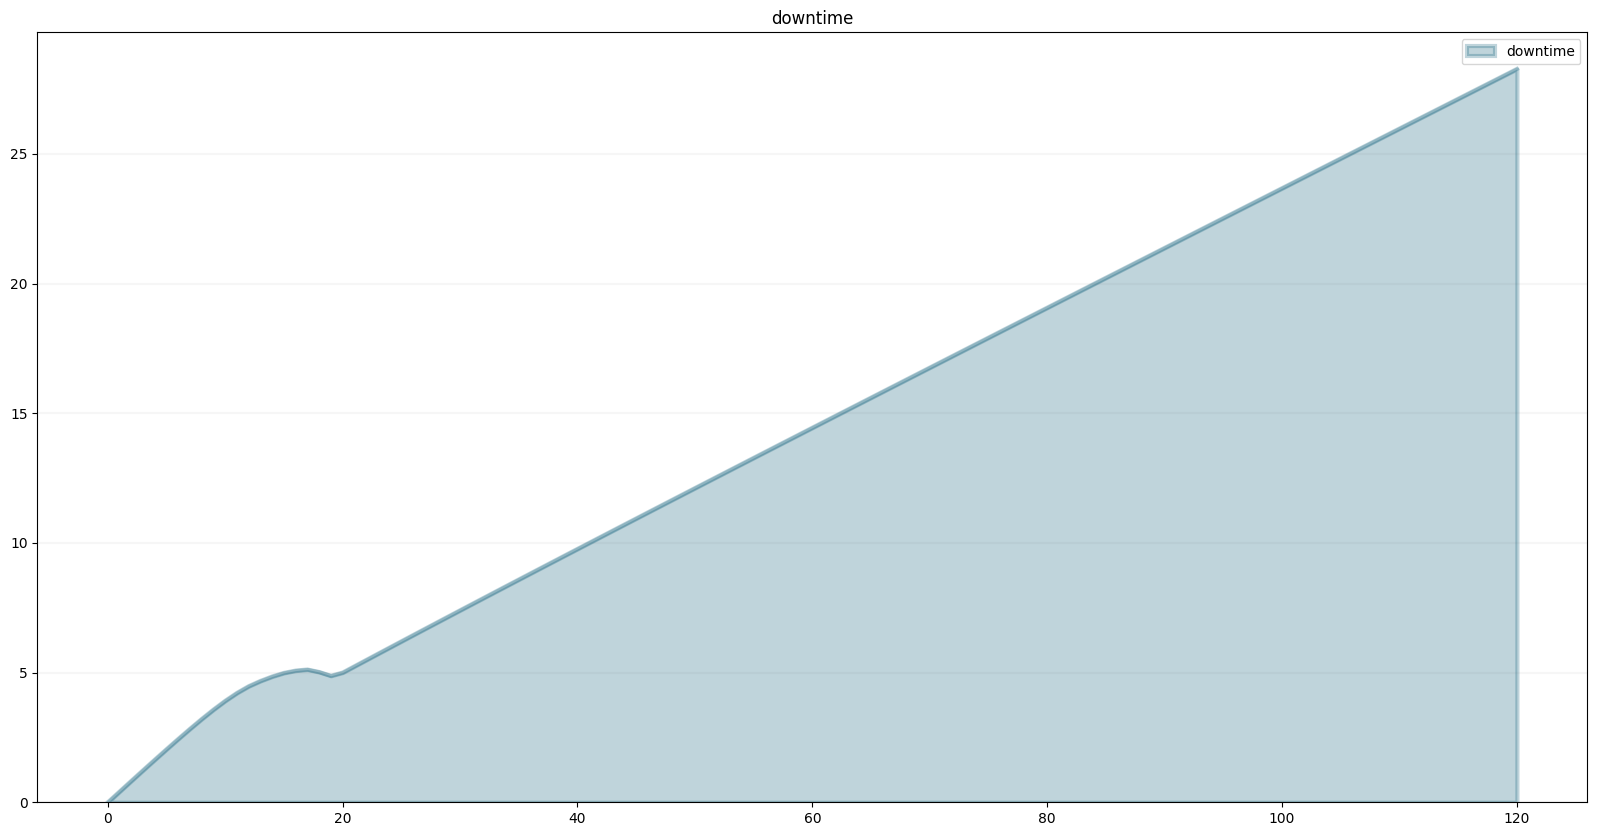

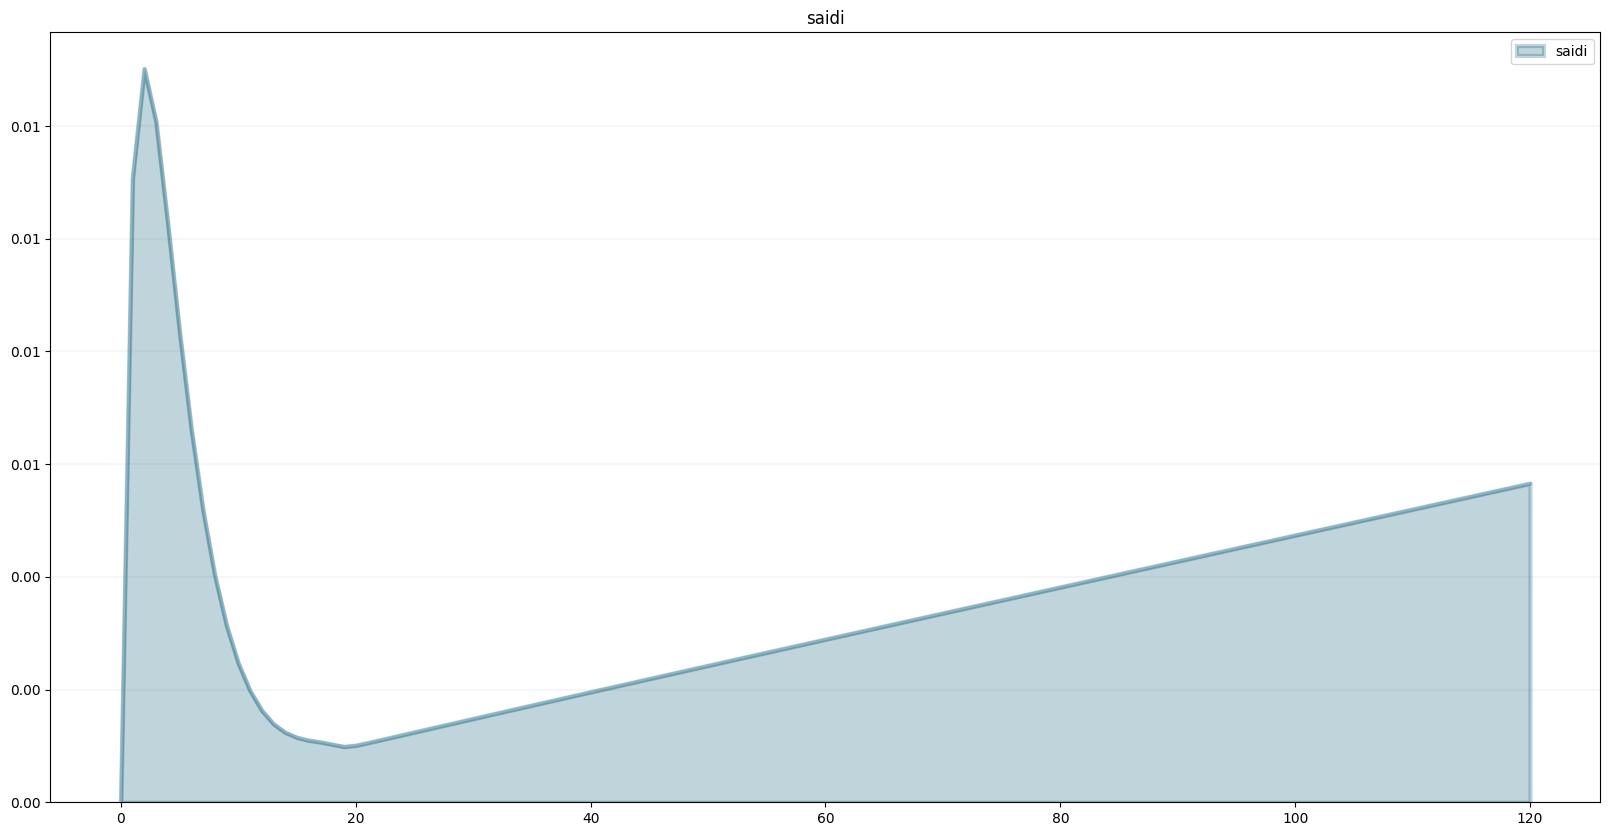

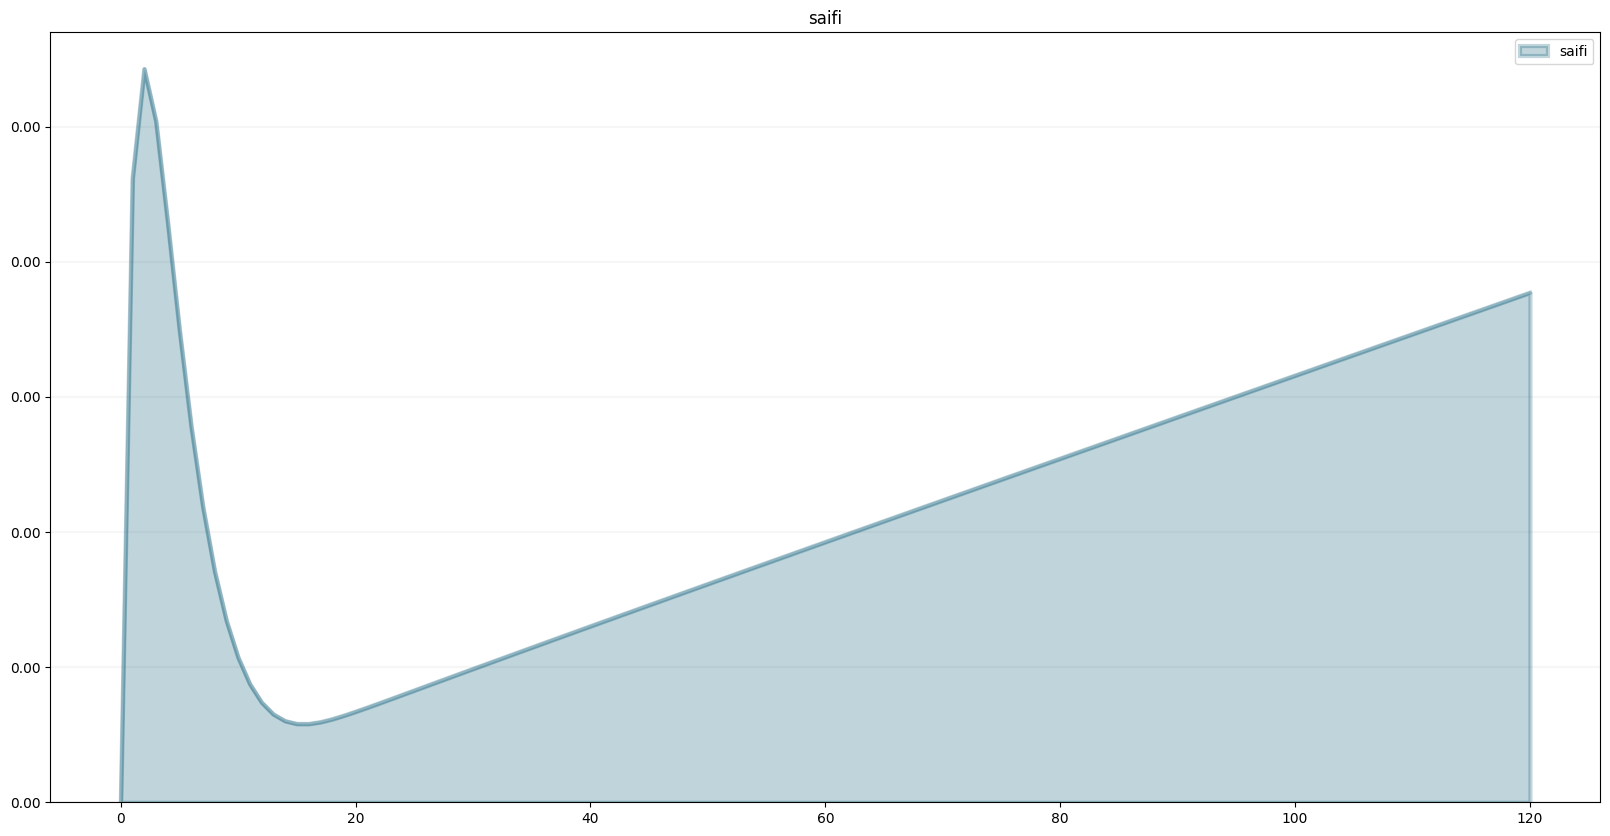

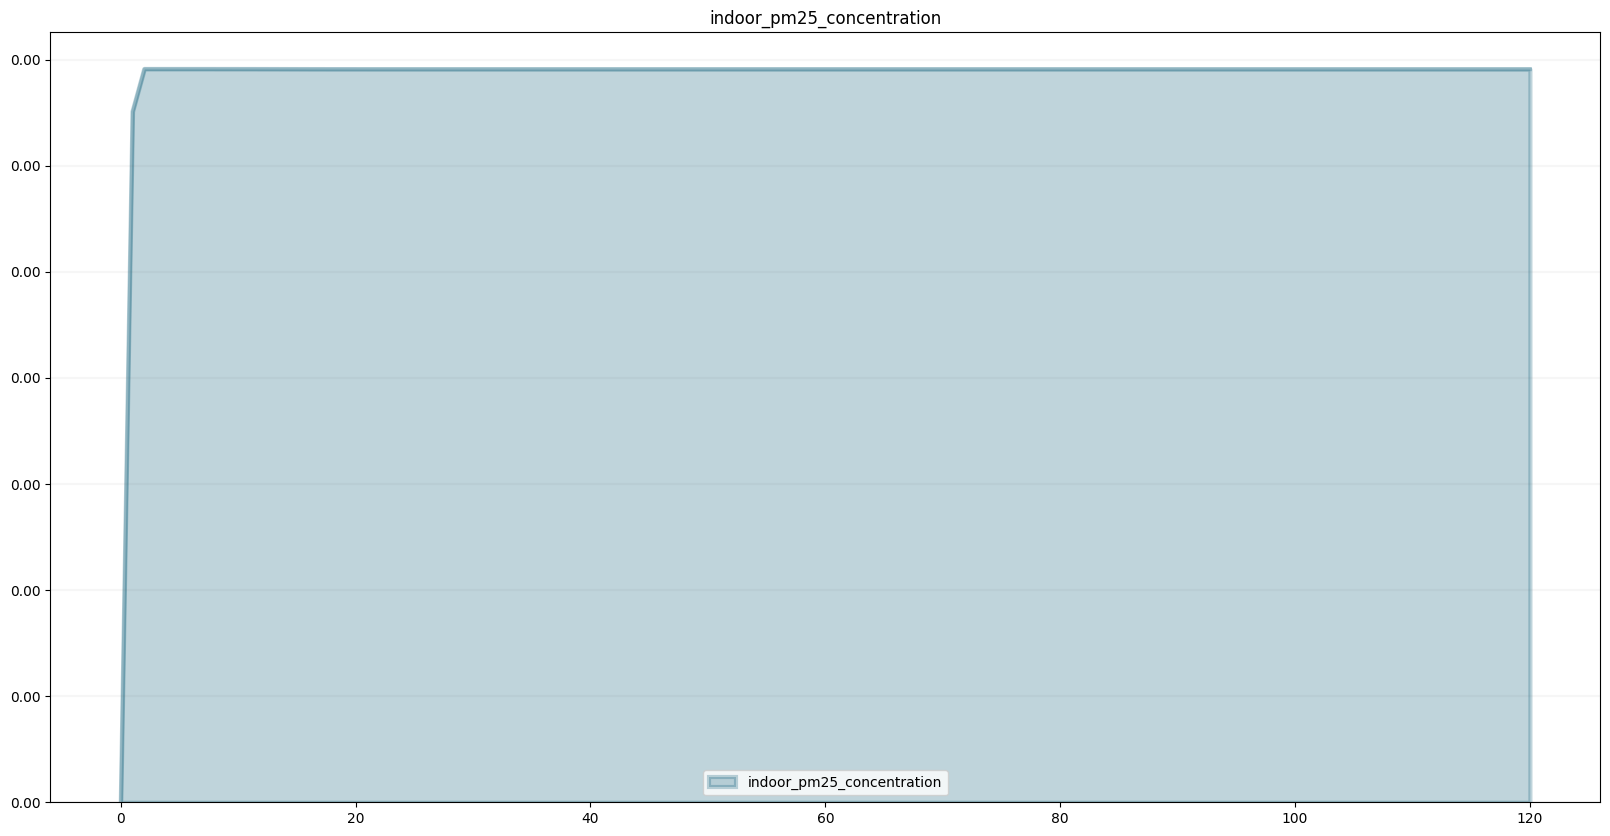

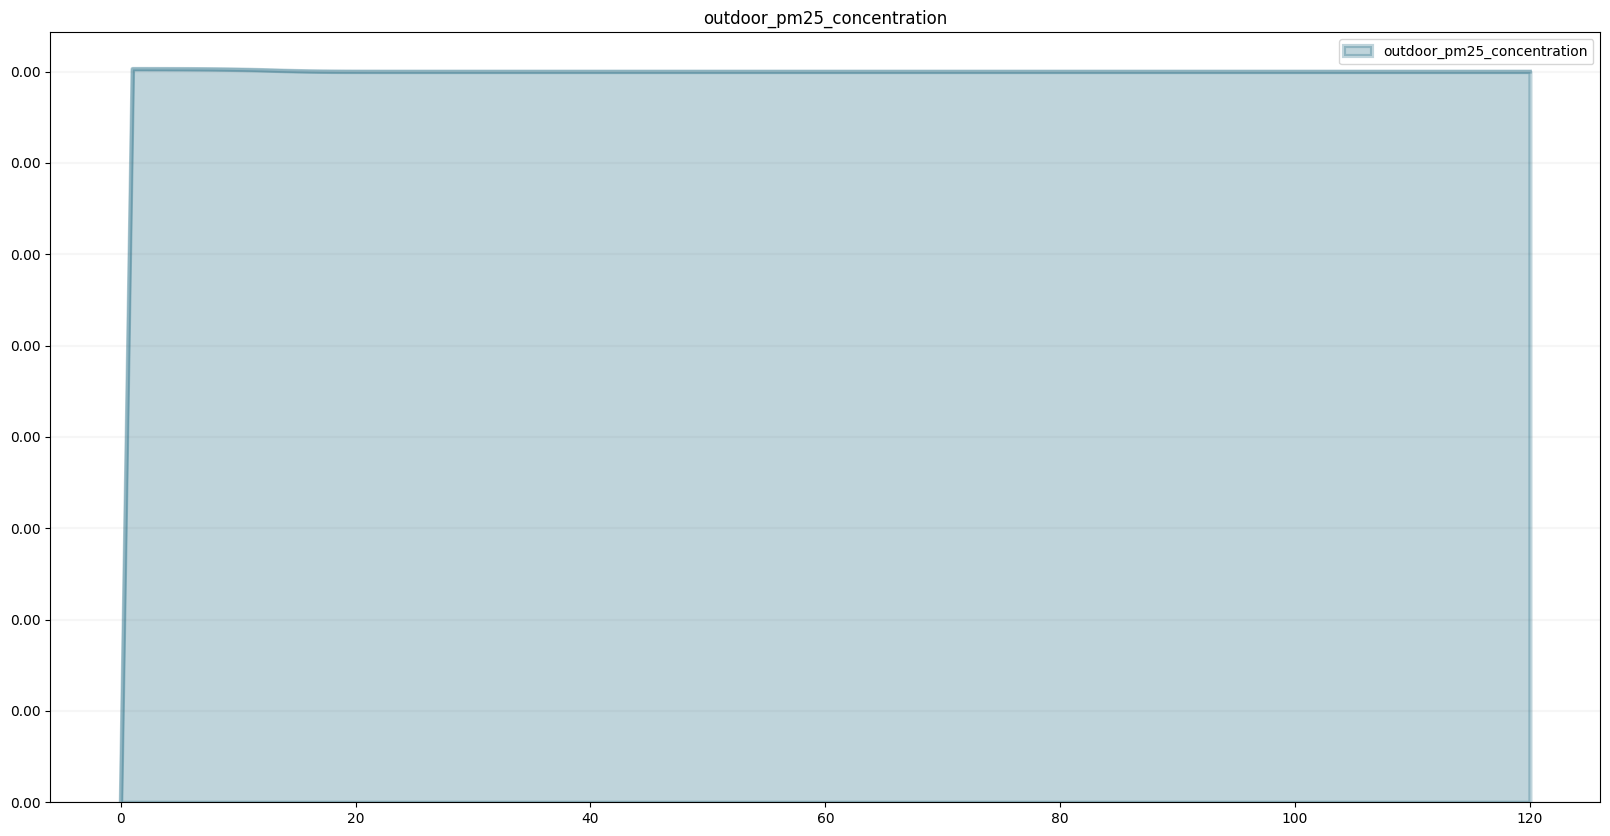

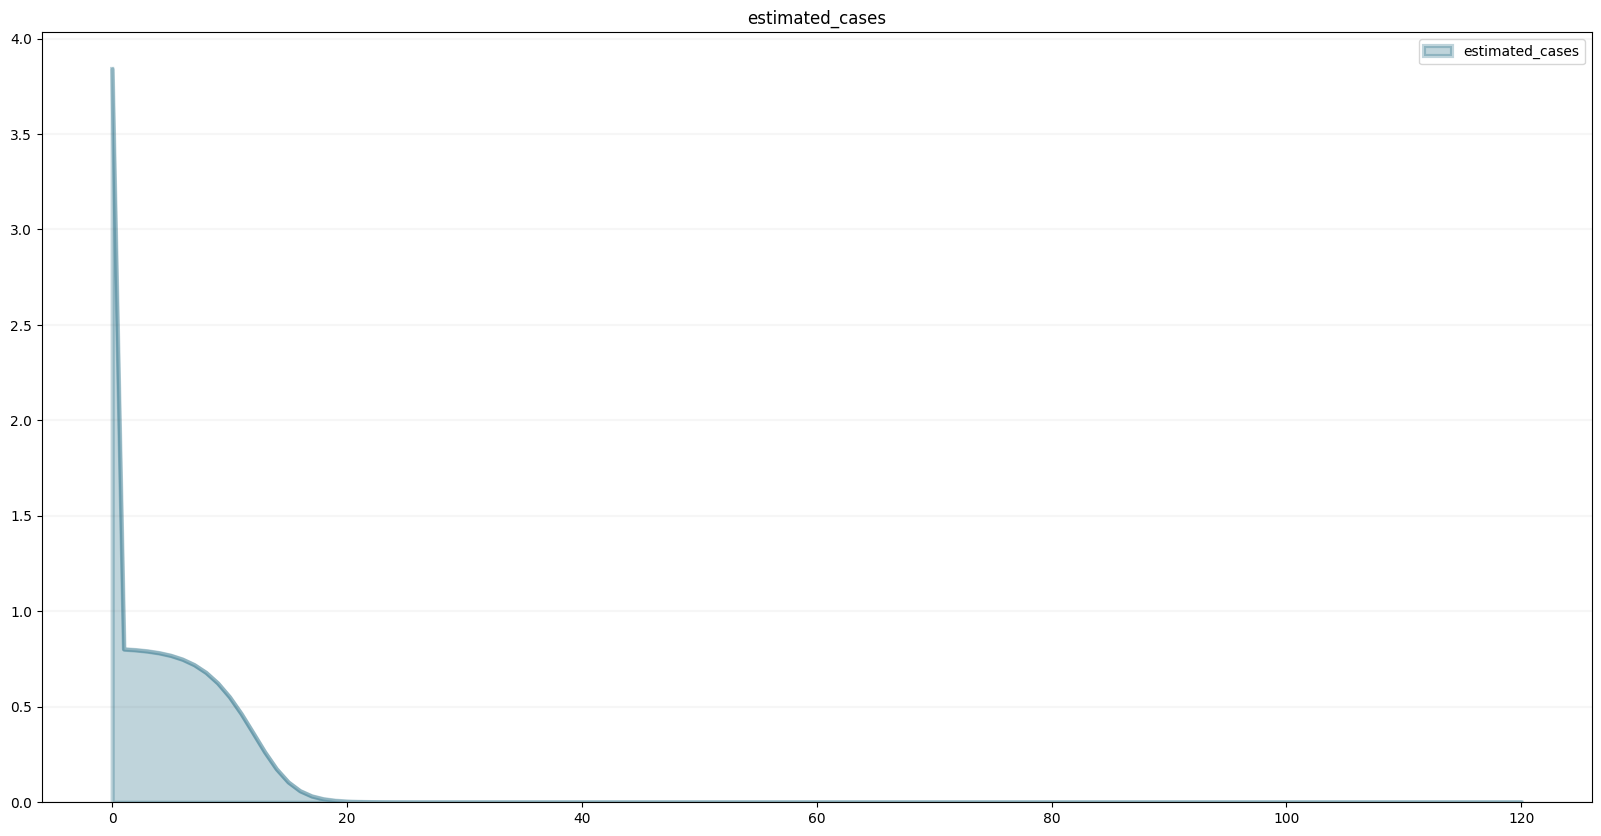

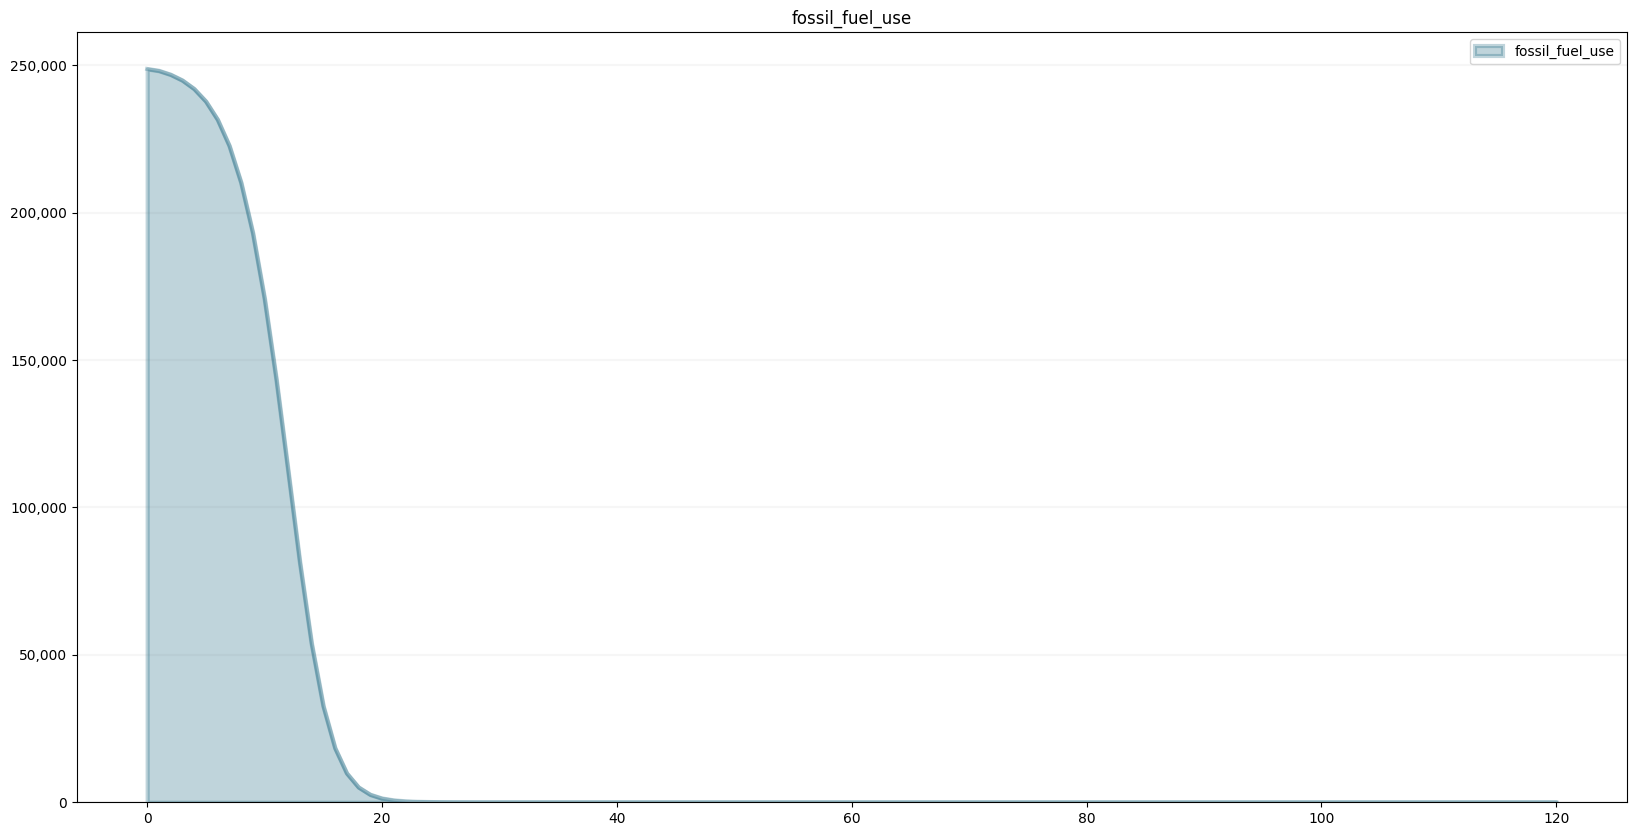

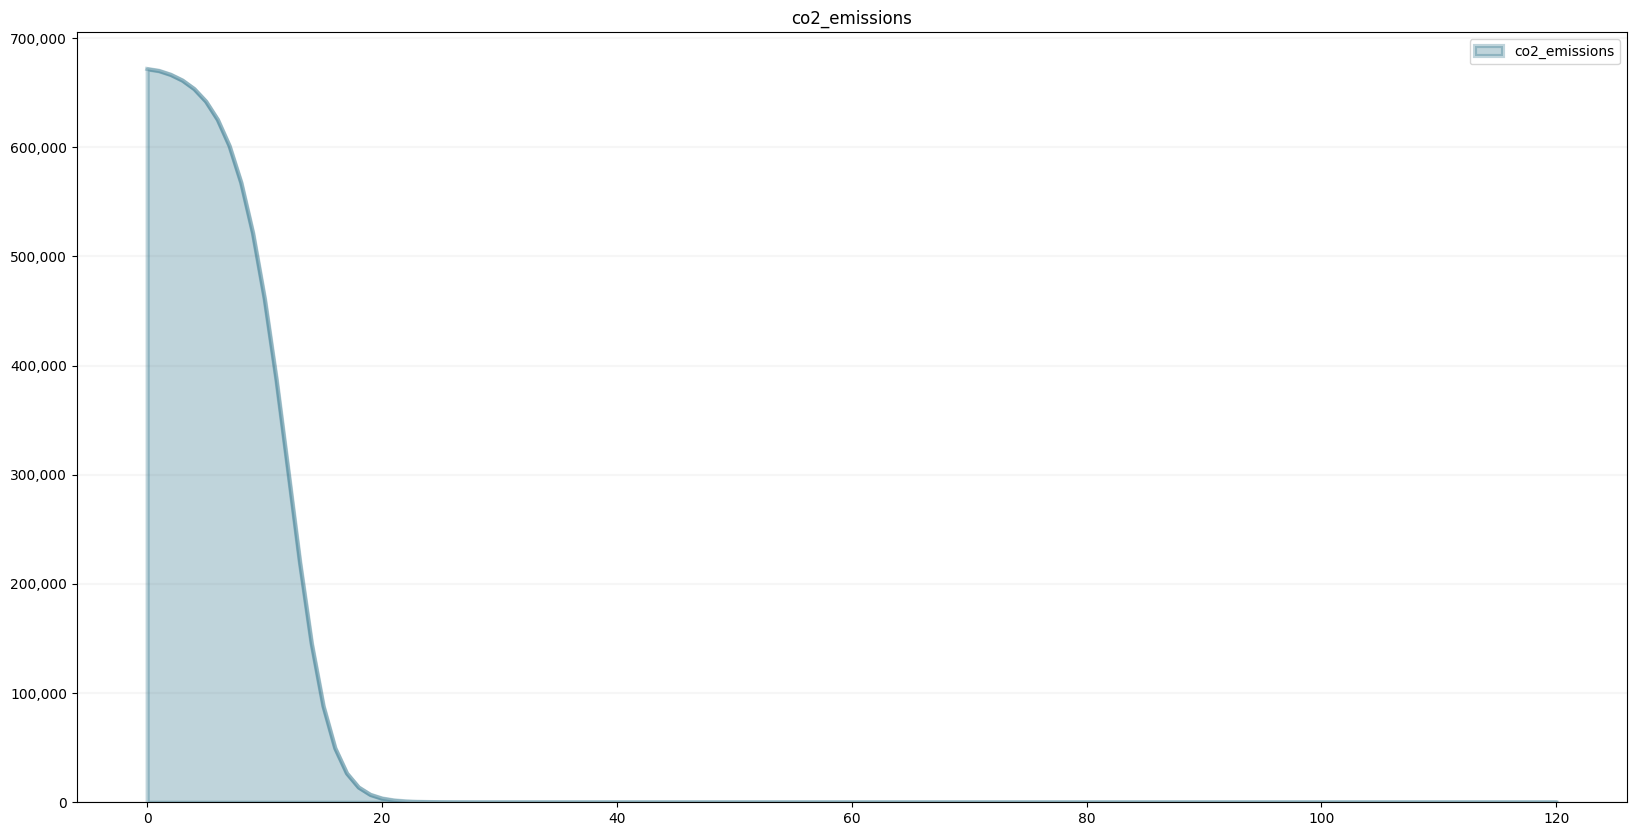

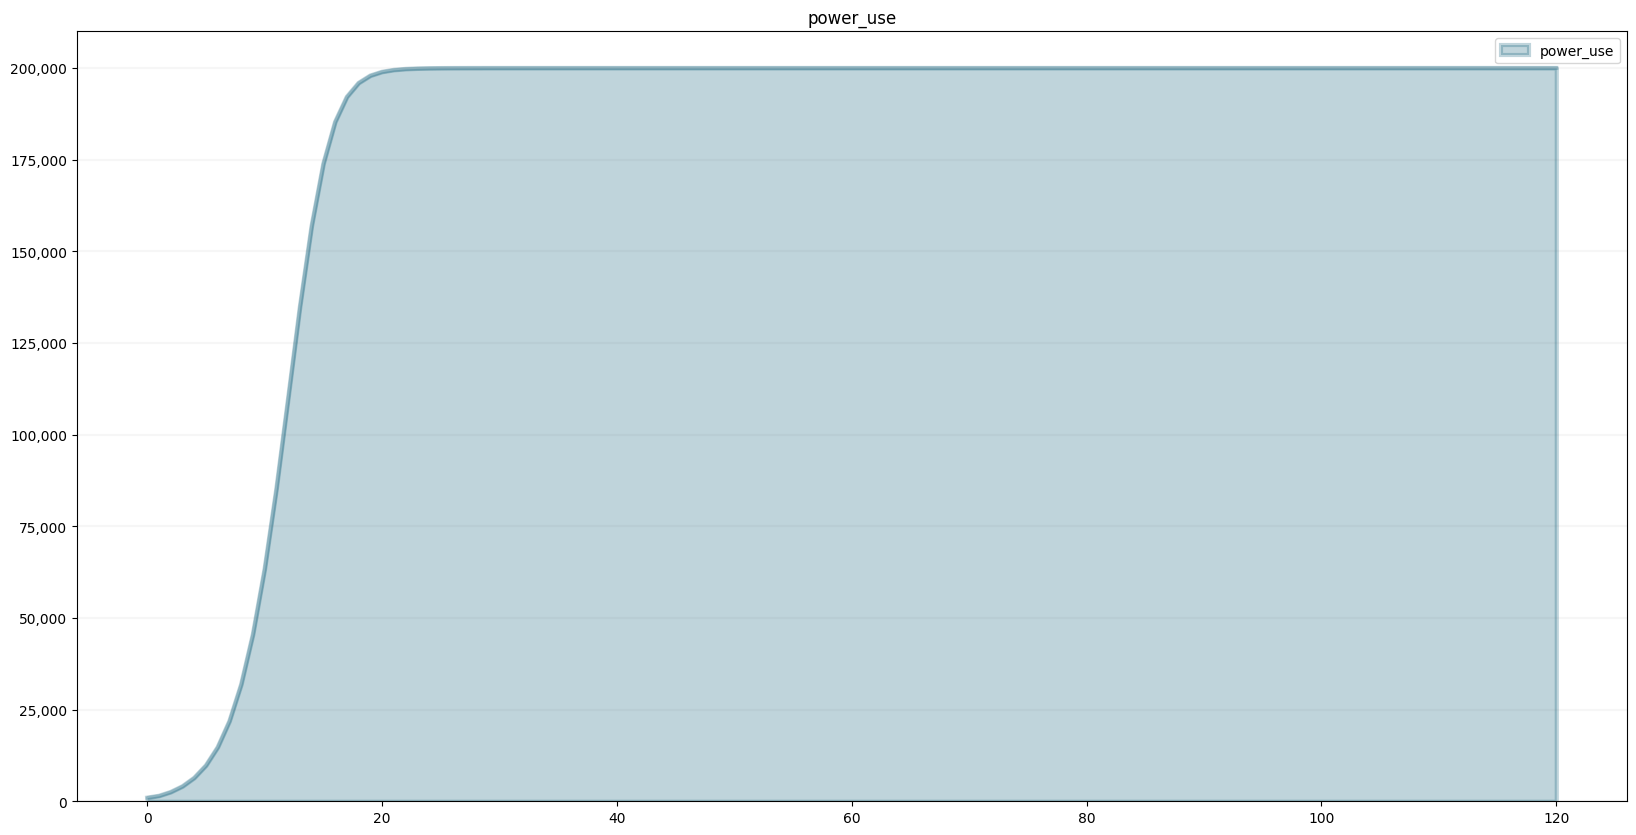

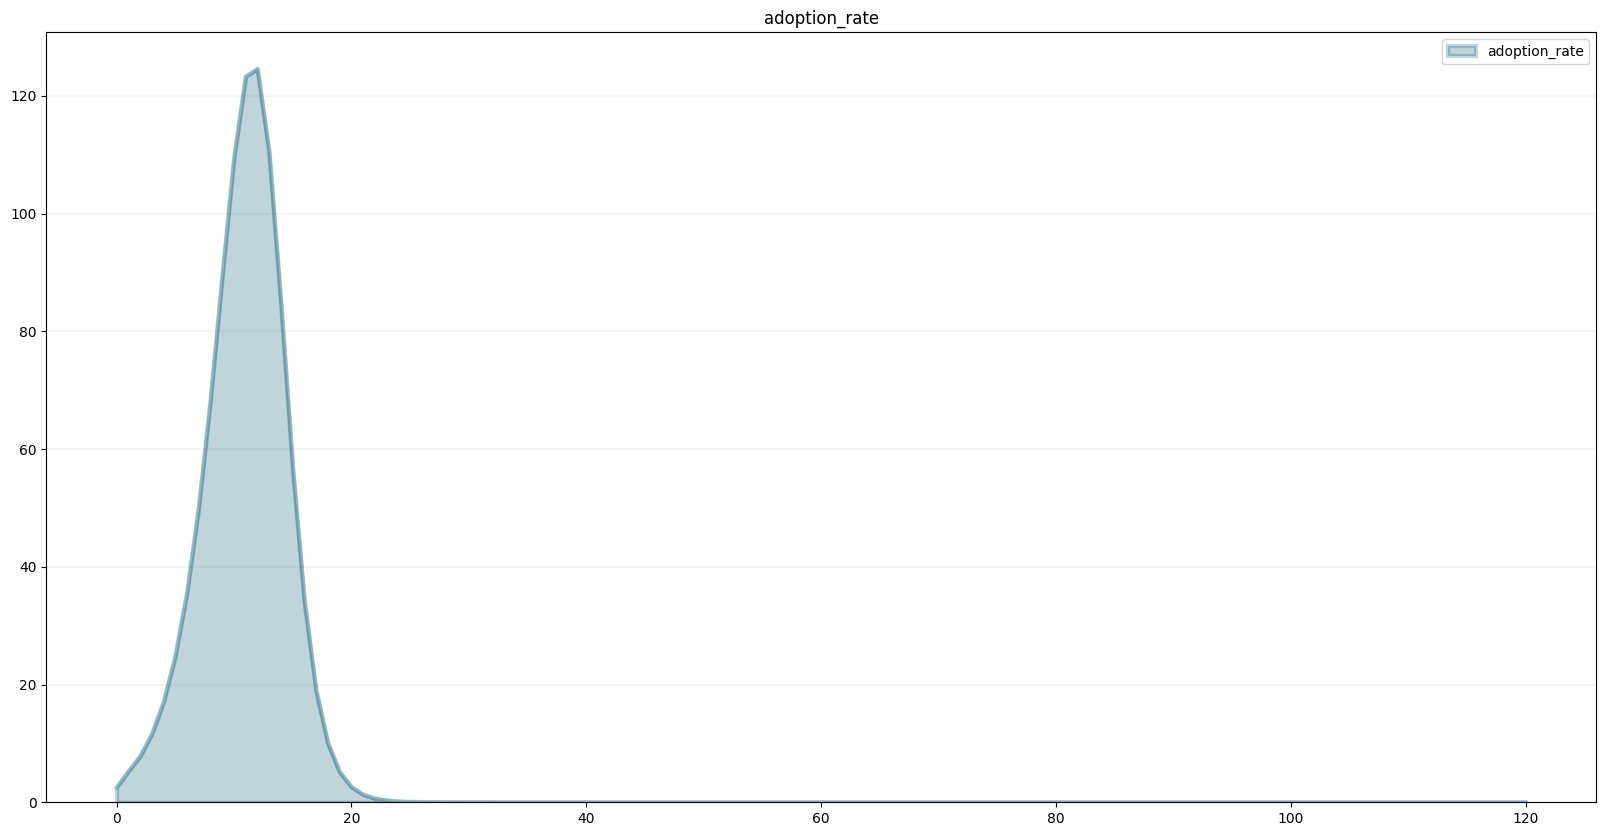

In [99]:
net_microgrid_income = model.stock("net_microgrid_income")
no_of_failures = model.stock("no_of_failures")
no_of_components = model.stock("no_of_components")
no_of_current_repairs = model.stock("no_of_current_repairs")


# -----------------------------
# Flows
# -----------------------------
adoption_rate = model.flow("adoption_rate")
indoor_pm25_removal = model.flow("indoor_pm25_removal")
outdoor_pm25_removal = model.flow("outdoor_pm25_removal")
indoor_pm25_addition = model.flow("indoor_pm25_addition")
outdoor_pm25_addition = model.flow("outdoor_pm25_addition")

microgrid_income = model.flow("microgrid_income")
microgrid_expenditures = model.flow("microgrid_expenditures")

income_flow = model.flow("income_flow")
failure_rate = model.flow("failure_rate")
fixture_rate = model.flow("fixture_rate")

# -----------------------------
# Converters
# -----------------------------
demand = model.converter("demand")
power_use = model.converter("power_use")
fossil_fuel_use = model.converter("fossil_fuel_use")
fossil_fuel_purchase = model.converter("fossil_fuel_purchase")
savings = model.converter("savings")
social_influence = model.converter("social_influence")
co2_emissions = model.converter("co2_emissions")
pm25_emissions = model.converter("pm25_emissions")
pm25_concentration_indoor = model.converter("pm25_concentration_indoor")

mttr = model.converter("mttr")
saifi = model.converter("saifi")
saidi = model.converter("saidi")
reliability = model.converter("reliability")
no_of_customers = model.converter("no_of_customers")
downtime = model.converter("downtime")

# -----------------------------
# Constants
# -----------------------------
no_of_households = model.constant("no_of_households")
fossil_fuel_price = model.constant("fossil_fuel_price") 
alpha_1 = model.constant("alpha_1")
alpha_2 = model.constant("alpha_2")
microgrid_capacity = model.constant("microgrid_capacity")
demand_per_household = model.constant("demand_per_household")
fossil_use_per_household = model.constant("fossil_use_per_household")
baseline_adoption = model.constant("baseline_adoption")
emissions_factor = model.constant("emissions_factor")
emissions_factor_pm25 = model.constant("emissions_factor_pm25")
kitchen_volume = model.constant("kitchen_volume")
city_volume = model.constant("city_volume")
air_change_rate = model.constant("air_change_rate")
wind_speed = model.constant("wind_speed")
kitchen_fraction = model.constant("kitchen_fraction")
initial_failure_rate = model.converter("initial_failure_rate")


pm25_exposure = model.converter("pm25_exposure")
estimated_cases = model.converter("estimated_cases")
avoided_cases = model.converter("avoided_cases")

incident_rate = model.converter("incident_rate")

cost_per_kwh = model.constant("cost_per_kwh")
no_of_components_initial_value = model.constant("no_of_components_initial_value")


# -----------------------------
# Equations
# -----------------------------

# Demand and energy use
demand.equation = demand_per_household.value * households_connected
power_use.equation = sd.min(demand, microgrid_capacity.value)

# income generated per time step
income_flow.equation = power_use * cost_per_kwh.value

# Stock: income accumulates the inflow
net_microgrid_income.equation = income_flow

# Maintenance delay improves with higher income
mttr.equation = sd.lookup(
    net_microgrid_income,
    [(0, 48), (30000000, 42), (70000000, 36), (100000000, 30)]
)

#failure rate flow
failure_rate.equation = initial_failure_rate.value*no_of_components

#number of failures stock
no_of_failures.equation = failure_rate

#fixture rate flow
fixture_rate.equation = no_of_current_repairs/mttr

#number of components stock
no_of_components.equation = fixture_rate - failure_rate

#number of components being repaired
no_of_current_repairs.equation = failure_rate - fixture_rate

# Failure rate depends on maintenance delay
downtime.equation = mttr * no_of_failures

# number of customers
no_of_customers.equation = households_connected*5

# SAIDI (interruptions per customer)
saidi.equation = downtime / sd.max(1, no_of_customers)

# SAIFI (interruptions per customer)
saifi.equation = no_of_failures / sd.max(1, no_of_customers)

# Reliability improves as SAIFI decreases
reliability.equation = 1/(1+30*saifi)

# Fossil fuel use avoided
fossil_fuel_use.equation = fossil_use_per_household.value * households_not_connected
fossil_fuel_purchase.equation = fossil_fuel_use * fossil_fuel_price.value

# Savings from avoided fossil fuel
savings.equation = (fossil_use_per_household.value * fossil_fuel_price.value* no_of_households.value) - fossil_fuel_purchase

# Social influence (bounded)
social_influence.equation = households_connected /sd.max(1, no_of_households.value)

# Adoption flow
adoption_rate.equation = households_not_connected * ((alpha_1.value * savings) + (alpha_2.value * social_influence) + (0.0005 * avoided_cases))

# CO2 emissions from fossil fuel use
co2_emissions.equation = fossil_fuel_use *emissions_factor.value

# pm 2.5 emissions from fossil fuel use
pm25_emissions.equation = fossil_use_per_household.value *emissions_factor_pm25.value

# indoor pm 2.5 concentration from fossil fuel use
#pm25_concentration_indoor.equation =(((pm25_emissions*kitchen_fraction)/(kitchen_volume*air_change_rate))+(((pm25_emissions*(1-kitchen_fraction))*households_not_connected)/(city_volume*wind_speed)))

# Indoor pm 2.5 flows
indoor_pm25_removal.equation = indoor_pm25_concentration
indoor_pm25_addition.equation = ((pm25_emissions*kitchen_fraction.value)/(kitchen_volume.value*air_change_rate.value))+outdoor_pm25_concentration

# Outdoor pm 2.5 flows
outdoor_pm25_removal.equation = outdoor_pm25_concentration
outdoor_pm25_addition.equation = (((households_not_connected*((pm25_emissions*(1-kitchen_fraction.value))+((air_change_rate.value*indoor_pm25_concentration)/kitchen_volume.value)))*10000)/(city_volume.value*wind_speed.value))+8e-6

pm25_exposure.equation = 0.61*indoor_pm25_concentration*1e6 # scale the value
estimated_cases.equation = (households_not_connected*5)*incident_rate.value*(1-(1/(1+(0.3*(1-(sd.exp(-1.2*(pm25_exposure-2.5)**1.2)))))))
avoided_cases.equation = estimated_cases(0)-estimated_cases

# Stock integration
households_connected.equation = adoption_rate
households_not_connected.equation = -adoption_rate
indoor_pm25_concentration.equation = indoor_pm25_addition-indoor_pm25_removal
outdoor_pm25_concentration.equation = outdoor_pm25_addition-outdoor_pm25_removal



# -----------------------------
# Initial values
# -----------------------------
no_of_households.equation = 1000.0
households_connected.initial_value = 5.0 
households_not_connected.initial_value = 995.0

indoor_pm25_concentration.initial_value = 0.0
outdoor_pm25_concentration.initial_value = 0.0

fossil_fuel_price.equation = 100
alpha_1.equation = 0.00000002
alpha_2.equation = 0.000001
microgrid_capacity.equation = 1e7
demand_per_household.equation = 200
fossil_use_per_household.equation = 250
emissions_factor.equation = 2.7
emissions_factor_pm25.equation = 15
kitchen_volume.equation = 20
city_volume.equation = 1e11
air_change_rate.equation = 2*720
wind_speed.equation = 5*2592000
kitchen_fraction.equation = 0.001
incident_rate.equation = 7e-4
cost_per_kwh.equation = 57
initial_failure_rate.equation = (6e-6)*720

no_of_failures.initial_value = 0.0
no_of_components_initial_value.equation = 2.0
no_of_components.initial_value = no_of_components_initial_value.value
no_of_current_repairs.initial_value = 0.0
# -----------------------------
# Plots
# -----------------------------
print(indoor_pm25_concentration(5),indoor_pm25_concentration(101))
print(outdoor_pm25_concentration(5),outdoor_pm25_concentration(100))
print(no_of_components_initial_value.value)
#print(failure_rate(5),failure_rate(700))
#failure_rate.plot()
mttr.plot()
failure_rate.plot()
fixture_rate.plot()
no_of_components.plot()
no_of_current_repairs.plot()
no_of_failures.plot()
reliability.plot()
net_microgrid_income.plot()
downtime.plot()
saidi.plot()
saifi.plot()
indoor_pm25_concentration.plot()
outdoor_pm25_concentration.plot()
estimated_cases.plot()
#avoided_cases.plot()
fossil_fuel_use.plot()
#pm25_emissions.plot()
#pm25_concentration_indoor.plot()
co2_emissions.plot()
power_use.plot()
#households_connected.plot()
#households_not_connected.plot()
adoption_rate.plot()



In [7]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd
from BPTK_Py import Agent
from BPTK_Py import Model
from BPTK_Py import Event
from BPTK_Py import DataCollector
from BPTK_Py import SimultaneousScheduler
class Household(Agent):
    def initialize(self):
        self.agent_type = "household"
        self.state = "unconnected"
        self.set_property("income", {"type": "Double", "value": 0})
        self.set_property("women", {"type": "Agent", "value": None})
        self.set_property("men", {"type": "Agent", "value": None})
        self.set_property("children", {"type": "Agent", "value": None})
        self.set_property("task", {"type": "Agent", "value": None})
        self.set_property("electric_stove", {"type": "String", "value": "Unadopted"})
        self.set_property("electric_lighting", {"type": "String", "value": "Unadopted"})
        self.register_event_handler(["electric_stove"], "stove_adoption_decision", self.handle_stove_event)
        self.register_event_handler(["electric_lighting"], "lighting_adoption_decision", self.handle_stove_event)


    def handle_stove_event(self,event):
        if self.is_event_relevant(self.model.stove_success):
            self.state="connected"
        
class Women(Agent):
    def initialize(self):
        self.agent_type = "women"
        self.state = "unemployed"
        self.set_property("time_saved", {"type": "Double", "value": 0.0})
    #    self.register_event_handler(["unemployed"], "task_started", self.handle_employment_women_event)
    #    self.register_event_handler(["time_saved"], "task_progress", self.handle_saved_time_women_event)

    def handle_saved_time_women_event(self, event):
        if self.household.state == "connected":
            self.time_saved = 2.0


class Men(Agent):
    def initialize(self):
        self.agent_type = "Men"
        self.state = "employed"
        self.set_property("time_saved", {"type": "Double", "value": 0.0})
    #    self.register_event_handler(["unemployed"], "task_started", self.handle_employment_men_event)
    #    self.register_event_handler(["time_saved"], "task_progress", self.handle_saved_time_men_event)

    def handle_saved_time_men_event(self, event):
        if self.household.state == "connected":
            self.time_saved = 1.0
   
        

In [136]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd
from BPTK_Py import Agent
from BPTK_Py import Model
from BPTK_Py import Event
from BPTK_Py import DataCollector
from BPTK_Py import SimultaneousScheduler

class Person(Agent):
    def __init__(self, role):
        self.role = role
        self.income = 0
        self.employed = False
        self.study_time = 0
        self.household_work_time = 0

        if self.role == "man":
            self.employed = random.random() < 0.7
        elif self.role == "woman":
            self.employed = random.random() < 0.25
        elif self.role == "child":
            self.employed = False
    
    def update(self, electrified):
        if self.role == "man" and self.employed:
            self.income = 10 if electrified else 0
        elif self.role == "woman" and self.employed:
            self.income = 5 if electrified else 0
        elif self.role == "child":
            self.study_time += 2 if electrified else 0.5

class Household(Agent):
    def __init__(self, members, appliances, connected=False):
        self.members = members
        self.appliances = appliances
        self.connected = connected
        
    
    def step(self):
        for m in self.members:
            m.update(self.connected)
        if reliability > 0.95 and not self.connected:
            self.connected = True

        

    
    def total_income(self):
        return sum(m.income for m in self.members if m.role in ["man","woman"])
    
    def total_study_time(self):
        return sum(m.study_time for m in self.members if m.role == "child")

class ImpactEstimatorSD():
     def __init__(self,model):
        self.model = model
        
        # stocks
        self.households_connected = model.stock("households_connected")
        self.households_not_connected = model.stock("households_not_connected")
        
        #flows
        self.customer_acquisition=model.flow("customer_acquisition")
        self.household_microgrid_adoption = model.flow("household_microgrid_adoption")
        self.social_influence_microgrid = model.converter("social_influence_microgrid")
        self.no_of_customers = model.converter("no_of_customers")

        #constants
        self.no_of_households = model.constant("no_of_households")
        
        
        #equations
        self.social_influence_microgrid.equation = self.households_connected/self.no_of_households
        self.household_microgrid_adoption.equation = self.households_not_connected * ((1e-2 * reliability) + (0.5e-2*self.social_influence_microgrid))
        self.households_connected.equation = self.household_microgrid_adoption
        self.households_not_connected.equation = -self.household_microgrid_adoption

        #initialise model
        no_of_households.equation = 600.0
        households_connected.initial_value = 0.0
        households_not_connected.initial_value = no_of_households

         


def create_household():
    members = []
    
    # Add men (probability-based)
    if random.random() < 0.4:  # 40% chance
        members.append(Person("man"))
    
    # Add women (probability-based)
    if random.random() < 0.7:  # 70% chance
        members.append(Person("woman"))
    
    # Add children (random number between 0 and 3)
    num_children = random.randint(0, 3)
    for _ in range(num_children):
        members.append(Person("child"))
    

    appliances = []
    # Add men (probability-based)
    if random.random() < 0.2:  # 40% chance
        appliances.append("electric_stove")

    # Add men (probability-based)
    if random.random() < 0.4:  # 40% chance
        appliances.append("electric_lighting")

     # Random electrification status (initially)
    connected = random.random() < 0.5  # 50% chance connected
    
    return Household(members, appliances, connected)


# Example setup
households = [create_household() for _ in range(600)]


for step in range(5):
    for h in households:
        h.step()
    avg_income = sum(h.total_income() for h in households) / len(households)
    avg_study = sum(h.total_study_time() for h in households) / len(households) 
    print(f"Step {step}: Avg Income={avg_income:.2f}, Avg Study={avg_study:.2f}")
    connected_count = sum(1 for h in households if h.connected)
    print(f"Number of connected households: {connected_count}")





Step 0: Avg Income=1.52, Avg Study=1.75
Number of connected households: 600
Step 1: Avg Income=3.43, Avg Study=4.64
Number of connected households: 600
Step 2: Avg Income=3.43, Avg Study=7.54
Number of connected households: 600
Step 3: Avg Income=3.43, Avg Study=10.43
Number of connected households: 600
Step 4: Avg Income=3.43, Avg Study=13.32
Number of connected households: 600


In [142]:
from BPTK_Py import Model, sd_functions as sd
from BPTK_Py import Agent, SimultaneousScheduler, DataCollector
import random

# --- System Dynamics Model ---
class MicrogridModel(Model):
    def __init__(self,model):
        super().__init__()
        self.model = model
        
        self.capacity = model.stock("capacity")
        self.expansion = model.flow("expansion")
        self.tariff = model.converter("tariff")
        self.reliability = model.converter("reliability")
        self.capacity.initial_value=100
        self.expansion.equation=10
        self.tariff=10
       # self.reliability=0.9
        

# --- Household Agent ---
class Household(Agent):
    def __init__(self, members, connected=False):
        super().__init__()
        self.members = members
        self.connected = connected

    def step(self, grid_model):
        # Household decision depends on SD variables
        tariff = grid_model["tariff"]
        reliability = grid_model["reliability"]

        if not self.connected and self.reliability > 0.95:
            self.connected = True

        # Update members
        for m in self.members:
            m.update(self.connected)

# --- Simulation Setup ---
grid_model = MicrogridModel(self)
households = [Household([Person("man"), Person("woman"), Person("child")]) for _ in range(600)]
scheduler = SimultaneousScheduler(households)
collector = DataCollector()

for step in range(10):
    # Advance SD model
    grid_model.step()

    # Advance ABM agents with SD context
    scheduler.step(grid_model)

    # Collect metrics
    connected_count = sum(1 for h in households if h.connected)
    collector.collect("connected_households", step, connected_count)
    collector.collect("capacity", step, grid_model["capacity"])


NameError: name 'self' is not defined

In [158]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd
from BPTK_Py import Agent
from BPTK_Py import DataCollector
from BPTK_Py import SimultaneousScheduler
import random

# --- Household Agent ---
class Household(Agent):
    def initialize(self):
        self.agent_type = "household"
        self.state = "unconnected"
        # Random composition
        self.members = []
        if random.random() < 0.4:
            self.members.append("man")
        if random.random() < 0.7:
            self.members.append("woman")
        num_children = random.randint(0, 3)
        for _ in range(num_children):
            self.members.append("child")

    def electrify(self):
        self.state = "connected"


# --- System Dynamics Model ---
class ElectrificationSD:
    def __init__(self, model):
        self.model = model

        # Stocks
        self.connected_households = model.stock("connected_households")

        # Flows
        self.connection_flow = model.flow("connection_flow")

        # Converters
        self.reliability = model.converter("reliability")
        self.tariff = model.converter("tariff")
        self.subsidy = model.converter("subsidy")

        # Equations
        self.connected_households.equation = self.connection_flow
        self.connection_flow.equation = self.reliability * 10  # simple rule: more reliability → more connections

        # Initial values
        self.connected_households.initial_value = 0.0
        self.reliability.equation = 0.9
        self.tariff.equation = 10.0
        self.subsidy.equation = 0.0


# --- Hybrid Model ---
class ElectrificationHybrid(Model):
    def instantiate_model(self):
        super().instantiate_model()
        # Register agent factory
        self.register_agent_factory("household", lambda agent_id, model, properties: Household(agent_id, model, properties))
        # Attach SD model
        self.sd_model = ElectrificationSD(self)

    def configure(self, config):
        super().configure(config)
        # Configure SD parameters from config
        self.sd_model.reliability.equation = self.reliability
        self.sd_model.tariff.equation = self.tariff
        self.sd_model.subsidy.equation = self.subsidy

    def begin_round(self, time, sim_round, step):
        # Check how many households should be connected according to SD model
        required_connected = int(self.evaluate_equation("connected_households", time))
        current_connected = len([a for a in self.agents if a.state == "connected"])
        households_to_connect = required_connected - current_connected

        # Electrify households
        for h in self.agents:
            if households_to_connect <= 0:
                break
            if h.state == "unconnected":
                h.electrify()
                households_to_connect -= 1


# --- Simulation Setup ---
electrification_hybrid = ElectrificationHybrid(
    1, 120, dt=1, name="Electrification Hybrid",
    scheduler=SimultaneousScheduler(),
    data_collector=DataCollector()
)

electrification_hybrid.instantiate_model()

electrification_config = {
    "runspecs": {
        "starttime": 1,
        "stoptime": 120,
        "dt": 1.0
    },
    "properties": {
        "reliability": {"type": "Double", "value": 0.9},
        "tariff": {"type": "Double", "value": 10.0},
        "subsidy": {"type": "Double", "value": 0.0}
    },
    "agents": [
        {"name": "household", "count": 600}
    ]
}

electrification_hybrid.configure(electrification_config)
electrification_hybrid.run()
[electrification_hybrid.statistics().get(1.0*key) for key in range(2,10)]


# Inspect results
#print(electrification_hybrid.statistics().keys())


[{'household': {'connected': {'count': 9}, 'unconnected': {'count': 591}}},
 {'household': {'connected': {'count': 18}, 'unconnected': {'count': 582}}},
 {'household': {'connected': {'count': 27}, 'unconnected': {'count': 573}}},
 {'household': {'connected': {'count': 36}, 'unconnected': {'count': 564}}},
 {'household': {'connected': {'count': 45}, 'unconnected': {'count': 555}}},
 {'household': {'connected': {'count': 54}, 'unconnected': {'count': 546}}},
 {'household': {'connected': {'count': 63}, 'unconnected': {'count': 537}}},
 {'household': {'connected': {'count': 72}, 'unconnected': {'count': 528}}}]

In [ ]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd
from BPTK_Py import Agent
from BPTK_Py import DataCollector
from BPTK_Py import SimultaneousScheduler
import random

# --- Household Agent ---
class Household(Agent):
    def initialize(self):
        self.agent_type = "household"
        self.state = "unconnected"
        self.members = []
        if random.random() < 0.4:
            self.members.append({"role":"man","employed":random.random()<0.7,"income":0})
        if random.random() < 0.7:
            self.members.append({"role":"woman","employed":random.random()<0.25,"income":0})
        num_children = random.randint(0, 3)
        for _ in range(num_children):
            self.members.append({"role":"child","study_time":0})

    def electrify(self):
        self.state = "connected"

    def step(self):
        if self.state == "connected":
            for m in self.members:
                if m["role"] in ["man","woman"] and m["employed"]:
                    m["income"] += 10 if m["role"]=="man" else 5
                elif m["role"]=="child":
                    m["study_time"] += 2
        else:
            for m in self.members:
                if m["role"] in ["man","woman"] and m["employed"]:
                    m["income"] += 2 if m["role"]=="man" else 1
                elif m["role"]=="child":
                    m["study_time"] += 0.5

    def total_income(self):
        return sum(m.get("income",0) for m in self.members if m["role"] in ["man","woman"])

    def total_study_time(self):
        return sum(m.get("study_time",0) for m in self.members if m["role"]=="child")


# --- System Dynamics Model ---
class ElectrificationSD:
    def __init__(self, model):
        self.model = model

        # Stocks
        self.households_connected = model.stock("households_connected")
        self.households_not_connected = model.stock("households_not_connected")
        self.net_microgrid_income = model.stock("net_microgrid_income")
        self.no_of_failures = model.stock("no_of_failures")
        self.no_of_components = model.stock("no_of_components")
        self.no_of_current_repairs = model.stock("no_of_current_repairs")

        self.net_microgrid_income = model.stock("net_microgrid_income")
        self.no_of_failures = model.stock("no_of_failures")
        self.no_of_components = model.stock("no_of_components")
        self.no_of_current_repairs = model.stock("no_of_current_repairs")

        # Flows
                
        self.connection_flow = model.flow("connection_flow")
        self.household_microgrid_adoption = model.flow("household_microgrid_adoption")
        self.microgrid_income = model.flow("microgrid_income")
        self.microgrid_expenditures = model.flow("microgrid_expenditures")
        self.microgrid_income_flow = model.flow("microgrid_income_flow")
        self.failure_rate = model.flow("failure_rate")
        self.fixture_rate = model.flow("fixture_rate")

        # Converters
        self.power_use = model.converter("power_use")
        self.failure_rate_multiplier =  model.converter("failure_rate_multiplier")
        self.mttr = model.converter("mttr")
        self.saifi = model.converter("saifi")
        self.saidi = model.converter("saidi")
        self.no_of_customers = model.converter("no_of_customers")
        self.downtime = model.converter("downtime")
        self.reliability = model.converter("reliability")
        self.social_influence_microgrid = model.converter("social_influence_microgrid")
        self.baseline_demand = model.converter("baseline_demand")

        self.tariff = model.converter("tariff")
        self.subsidy = model.converter("subsidy")

        # Aggregate social/economic converters
        self.avg_income = model.converter("avg_income")
        self.avg_study_time = model.converter("avg_study_time")

        self.baseline_household_demand = model.constant("baseline_household_demand")
        self.no_of_households = model.constant("no_of_households")
        self.microgrid_capacity = model.constant("microgrid_capacity")
        self.initial_failure_rate = model.constant("initial_failure_rate")
        self.cost_per_kwh = model.constant("cost_per_kwh")
        self.no_of_components_initial_value = model.constant("no_of_components_initial_value")

        # Equations
        #self.connected_households.equation = self.connection_flow
        #self.connection_flow.equation = self.avg_study_time

        self.social_influence_microgrid.equation = self.households_connected/self.no_of_households
        self.household_microgrid_adoption.equation = self.households_not_connected * ((1e-2 * self.reliability) + (0.5e-2*self.social_influence_microgrid))#+(5e-4*health_improvements)+(1e-2*cost_savings_overall))
        self.households_connected.equation = self.household_microgrid_adoption
        self.households_not_connected.equation = -self.household_microgrid_adoption
        self.baseline_demand.equation = self.baseline_household_demand * self.households_connected
        self.power_use.equation = sd.min(self.baseline_demand,self.microgrid_capacity)
        

        # These will be updated dynamically from agents in begin_round
        self.avg_income.equation = 0.0
        self.avg_study_time.equation = 0.0 #please work

        # Initial values
        
        self.no_of_households.equation = 600.0
        self.households_connected.initial_value = 0.0 
        self.households_not_connected.initial_value = self.no_of_households
        self.microgrid_capacity.equation = 1000000.0 #KW
        self.cost_per_kwh.equation = 0.18
        self.initial_failure_rate.equation = (6e-6)*720.0
        self.no_of_failures.initial_value = 0.0
        self.no_of_components_initial_value.equation = 2.0
        self.no_of_components.initial_value = self.no_of_components_initial_value
        self.no_of_current_repairs.initial_value = 0.0
        self.baseline_household_demand.equation = 200.0 #in kWh


# --- Hybrid Model ---
class ElectrificationHybrid(Model):
    def instantiate_model(self):
        super().instantiate_model()
        self.register_agent_factory("household", lambda agent_id, model, properties: Household(agent_id, model, properties))
        self.sd_model = ElectrificationSD(self)

    def configure(self, config):
        super().configure(config)
        self.sd_model.reliability.equation = self.reliability
        self.sd_model.tariff.equation = self.tariff
        self.sd_model.subsidy.equation = self.subsidy

        self.sd_model.no_of_households.equation = self.no_of_households
        self.sd_model.microgrid_capacity.equation = self.microgrid_capacity
        self.sd_model.cost_per_kwh.equation = self.cost_per_kwh
        self.sd_model.initial_failure_rate.equation = self.initial_failure_rate
        self.sd_model.no_of_components_initial_value.equation = self.no_of_components_initial_value
        self.sd_model.baseline_household_demand.equation = self.baseline_household_demand

    def begin_round(self, time, sim_round, step):
        # Update agent states
        for h in self.agents:
            h.step()

        # Aggregate outcomes from agents
        avg_income = sum(h.total_income() for h in self.agents) / len(self.agents)
        avg_study = sum(h.total_study_time() for h in self.agents) / len(self.agents)
        # Feed back into SD converters
        self.sd_model.avg_income.equation = avg_income
        self.sd_model.avg_study_time.equation = avg_study
        
        # Electrification decision based on SD reliability
        print(self.sd_model.households_connected(time))
        required_connected = int(self.sd_model.households_connected(time))
        #current_connected = len([a for a in self.agents if a.state == "connected"])
        #households_to_connect = required_connected - current_connected
        current_connected = len([a for a in self.agents if a.state == "connected"])
        households_to_connect = required_connected - current_connected
        #self.create_agents({"name":"customer","count":agents_needed})
        for h in self.agents:
            if households_to_connect <= 0:
                break
            if h.state == "unconnected":
                h.electrify()
                households_to_connect -= 1
                #print(households_to_connect)

        
        #print(avg_study)
        #print(self.sd_model.avg_study_time(time))
        
        #print(required_connected ,",", current_connected)
        #connected_count = sum(1 for a in self.agents if a.state == "connected")
        #print(f"Number of connected households: {connected_count}")


# --- Simulation Setup ---
electrification_hybrid = ElectrificationHybrid(
    1, 120, dt=1, name="Electrification Hybrid",
    scheduler=SimultaneousScheduler(),
    data_collector=DataCollector()

)

electrification_hybrid.instantiate_model()

electrification_config = {
    "runspecs": {
        "starttime": 1,
        "stoptime": 120,
        "dt": 1.0
    },
    "properties": {
        "reliability": {"type": "Double", "value": 0.9},
        "tariff": {"type": "Double", "value": 10.0},
        "subsidy": {"type": "Double", "value": 0.0},
        "no_of_households": {"type": "Double", "value": 600.0},
        "microgrid_capacity": {"type": "Double", "value": 1000000.0},#KW
        "cost_per_kwh": {"type": "Double", "value": 0.18},
        "initial_failure_rate": {"type": "Double", "value": (6e-6)*720.0},
        "no_of_components_initial_value": {"type": "Double", "value": 2.0},
        "baseline_household_demand": {"type": "Double", "value": 200.0}#KW
        
    },
    "agents": [
        {"name": "household", "count": 600}
    ]
}

electrification_hybrid.configure(electrification_config)
electrification_hybrid.run()
[electrification_hybrid.statistics().get(1.0*key) for key in range(2,10)]
stats = electrification_hybrid.statistics()

for t, values in stats.items():
    print(f"Time {t}: {values}")




In [12]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd
from BPTK_Py import Agent
from BPTK_Py import Event
from BPTK_Py import DataCollector
from BPTK_Py import SimultaneousScheduler
import random
import math


DISEASE_PARAMS = {
    "alpha": 0.3,
    "gamma":0.6,
    "delta":0.7,
    "c0":1,
    "baseline_incidence":200/100000
}

APPLIANCE_CATALOG = {
    "electric_cooker": {
        "cost": 500,
        "monthly_kwh": 30,
        "beta_0": -3.5,
        "beta_income": 0.00003,
        "beta_reliability": 5.5,
        "beta_social": 1.0,
        "beta_cost": 0.003,
        "beta_tariff": 3.5
    },
    "tv": {
        "cost": 300,
        "monthly_kwh": 5,
        "beta_0": -2.0,
        "beta_income": 0.00002,
        "beta_reliability": 0.5,
        "beta_social": 3.5,
        "beta_cost": 0.002,
        "beta_tariff": 2.5
    },
    "electric_lighting": {
        "cost": 50,
        "monthly_kwh": 3,
        "beta_0": -4.5,
        "beta_income": 0.00004,
        "beta_reliability": 3.5,
        "beta_social": 3.8,
        "beta_cost": 0.0001,
        "beta_tariff": 2.5
    }
}

FUEL_APPLIANCE_CATALOG = {
    "lpg_stove": {
        "hours_used": 2.5,
        "fuel_used_hour": 0.5,
        "cost_per_unit": 10, 
        "fuel_emission_factor_pm25": 15, #g/L
        "fuel_emission_factor_co2": 2.98,
        "kitchen_fraction": 0.25
    },
    "kerosene_lamp": {
        "hours_used": 5,
        "fuel_used_hour": 0.5,
        "cost_per_unit": 15, 
        "fuel_emission_factor_pm25": 10, #g/L
        "fuel_emission_factor_co2": 2.68,
        "kitchen_fraction": 0.3
    }
}

# --- Household Agent ---
class Household(Agent):
    def initialize(self):
        self.agent_type = "household"
        self.state = "unconnected"
        self.members = []
        #if random.random() < 0.4:
        self.members.append({"role":"man","employed":random.random()<0.7,"income":0,"exposure":0,"exposure_fraction":0.450,"age":random.randint(18, 59)})
        num_women = random.randint(1, 2)
        #if random.random() < 0.7:
        for _ in range(num_women):
            self.members.append({"role":"woman","employed":random.random()<0.25,"income":0,"exposure":0,"exposure_fraction":0.628,"age":random.randint(18, 59)})
        num_children = random.randint(0, 3)
        for _ in range(num_children):
            self.members.append({"role":"child","education_state":"","study_time":0,"schooling":0.0,"income":0,"exposure":0,"exposure_fraction":0.742,"gender":random.choice(["male","female"]),"age":random.randint(0, 15), "employed":"False"})
                
        self.fuel_appliances = {}  # name → owned (True/False)
        for name in FUEL_APPLIANCE_CATALOG:
            self.fuel_appliances[name] = True

        self.electric_appliances = {}  # name → owned (True/False)
        for name in APPLIANCE_CATALOG:
            self.electric_appliances[name] = False


    def electrify(self):
        self.state = "connected"

    def time_saved_men(self):
        if self.state == "connected":
            return 1   # hours/day saved
        return 0.0

    def time_saved_women(self):
        if self.state == "connected":
            return 2.5   # hours/day saved
        return 0.0
    

    def set_schooling(self):
        dropout_rate_baseline = 0.15
        for m in self.members:
            if m["age"] < 4:
                m["education_state"] = "not_started"
                m["schooling_years"] = 0
                return

            potential_years = min(m["age"] - 6, 12)

            completed_years = 0

            for year in range(int(potential_years)):
                if random.random() < dropout_rate_baseline:
                    break
                completed_years += 1

            m["schooling_years"] = completed_years

            if completed_years >= 12:
                m["education_state"] = "completed"
            elif completed_years < potential_years:
                m["education_state"] = "dropped_out"
            elif m["age"] < 18:
                m["education_state"] = "enrolled"
            else:
                m["education_state"] = "completed"

    def step(self,available_jobs):
        job_changes = 0.0
        def annual_to_monthly(percentage):
            return ((1+percentage)**(1/12))-1
            
        saved_hours_men = self.time_saved_men() #time saved from electrification that is dedicated to work
        saved_hours_women = self.time_saved_women() #time saved from electrification that is dedicated to work
        work_time_men = saved_hours_men * 0.4
        leisure_time_men = saved_hours_men * 0.5
        study_time_men = saved_hours_men * 0.1
        
        work_time_women = saved_hours_women * 0.4
        leisure_time_women = saved_hours_women * 0.4
        study_time_women = saved_hours_women * 0.2
        dropout_rate_baseline = 0.15
        baseline_monthly_wage_men = 130
        baseline_monthly_wage_women = 85
        baseline_schooling = 5
        error = 0.1
        employment_rate_baseline = annual_to_monthly(0.07)#0.07
        employment_rate_women_connected = annual_to_monthly(0.16)#0.16
        hourly_farm_wage = 2
        hourly_non_farm_wage = 7
        job_separation_rate = annual_to_monthly(0.02)#0.02
        electrification_effect_women = 0.9 #some studies suggest reduced female wages in areas of high electrification
        electrification_effect_men = 1.1 #elefrification is linked to increased wages for men
        working_days = 20 # number of working days in a monthly
        farm_work_shift = 0 #for farm work shift scenario. 1 for scenario, 0 otherwise
        non_farm_work_shift = 1 #for non-farm work shift scenario. 1 for scenario, 0 otherwise           

        for m in self.members:
            m["age"] += 1/12
            if self.state == "connected":
                dropout_rate = annual_to_monthly(dropout_rate_baseline*(1))#dropout_rate_baseline*(1-0.07)#(1-0.01244)
            else:
                dropout_rate = annual_to_monthly(dropout_rate_baseline)

             # Start school
            if m["age"] >= 6 and m["education_state"] == "not_started":
                m["education_state"] = "enrolled"

            # If enrolled → accumulate schooling
            if m["education_state"] == "enrolled":
                # Dropout event
                if random.random() < dropout_rate:
                    m["education_state"] = "dropped_out"
                else:
                    m["schooling_years"] += 1/12
                    # Completion condition
                    if m["schooling_years"] >= 12:
                        m["education_state"] = "completed"

            # Force exit at leaving age
            if m["age"] >= 18 and m["education_state"] == "enrolled":
                m["education_state"] = "completed"
                
       #     if m["role"]=="child" and m["employed"]==False and m["in_school"]:
       #         if random.random()<dropout_rate:
       #             m["in_school"] = False
       #         else:
       #             m["schooling"] += 1/12
               

         #employment decision 
        for m in self.members:
           
            if available_jobs <= 0:
                break
            employment_probability = 0.0
            if not m["employed"] and m["age"]<60:
                if m["role"] == "woman":
                    employment_probability = employment_rate_women_connected if self.state == "connected" else employment_rate_baseline
                elif m["role"] == "man":
                    employment_probability = employment_rate_baseline
                elif m["role"]=="child" and m["gender"] == "male" and m["age"]>=16:
                    employment_probability = employment_rate_baseline
                elif m["role"]=="child" and m["gender"] == "female" and m["age"]>=16:
                    employment_probability = employment_rate_women_connected if self.state == "connected" else employment_rate_baseline
                if random.random() < employment_probability: #probability of getting employed
                    m["employed"] = True
                    available_jobs -= 1
                    job_changes += 1


        for m in self.members:
            if m["employed"]:
                if m["role"] == "man":
                    if self.state == "connected":
                        m["income"] = ((baseline_monthly_wage_men*electrification_effect_men) + (work_time_men*working_days*hourly_non_farm_wage))
                    else:
                        m["income"] = baseline_monthly_wage_men
                elif m["role"] == "woman":
                    if self.state == "connected":
                        m["income"] = ((baseline_monthly_wage_women*electrification_effect_women) + ((work_time_women*working_days*hourly_farm_wage)*farm_work_shift) + (work_time_women*working_days*hourly_non_farm_wage)*non_farm_work_shift)
                    else:
                        m["income"] = baseline_monthly_wage_women
                elif m["role"]=="child" and m["gender"] == "male":
                    if self.state == "connected":
                        if (m["schooling"]-baseline_schooling) > 0:
                            m["income"] = ((baseline_monthly_wage_men*electrification_effect_men) + (work_time_men*working_days*hourly_non_farm_wage))*(1+0.096)**(m["schooling"]-baseline_schooling)# uses part of Mincer equation to view income effect of schooling
                        else:
                            m["income"] = ((baseline_monthly_wage_men*electrification_effect_men) + (work_time_men*working_days*hourly_non_farm_wage))# uses part of Mincer equation to view income effect of schooling
                    else:
                        m["income"] = baseline_monthly_wage_men
                elif m["role"]=="child" and m["gender"] == "female":
                    if self.state == "connected":
                        if (m["schooling"]-baseline_schooling) > 0:
                            m["income"] = (((baseline_monthly_wage_women*electrification_effect_women) + ((work_time_women*working_days*hourly_farm_wage)*farm_work_shift) + (work_time_women*working_days*hourly_non_farm_wage)*non_farm_work_shift))*(1+0.115)**(m["schooling"]-baseline_schooling)
                        else:
                            m["income"] = (((baseline_monthly_wage_women*electrification_effect_women) + ((work_time_women*working_days*hourly_farm_wage)*farm_work_shift) + (work_time_women*working_days*hourly_non_farm_wage)*non_farm_work_shift))
                    else:
                        m["income"] = baseline_monthly_wage_women
            if m["age"]>= 60:
                m["employed"] = False
                m["income"] = 0.0


        for m in self.members:
            if m["employed"] and random.random()<job_separation_rate:
                m["employed"] = False
                m["income"] = 0
                available_jobs += 1
                job_changes -= 1

        
        return job_changes          


    def total_income(self):
        return sum(m.get("income",0) for m in self.members)

    def total_study_time(self):
        return sum(m.get("study_time",0) for m in self.members if m["role"]=="child")
        

    def consider_appliance_adoption(self, reliability, social_influence,cost_per_kwh):
        income = self.total_income()

        for name, a in APPLIANCE_CATALOG.items():

            if self.electric_appliances[name]:
                continue  # already owned

            utility = (
                a["beta_0"]
                + a["beta_income"] * income
                + a["beta_reliability"] * reliability
                + a["beta_social"] * social_influence
                - a["beta_cost"] * a["cost"]
                - a["beta_tariff"] * cost_per_kwh
            )

            adoption_prob = 1 / (1 + math.exp(-utility))

            if random.random() < adoption_prob:
                if name == "electric_cooker":
                    self.electric_appliances[name] = True
                    self.fuel_appliances["lpg_stove"] = False
                elif name == "electric_lighting":
                    self.electric_appliances[name] = True
                    self.fuel_appliances["kerosene_lamp"] = False
                elif name == "tv":
                    self.electric_appliances[name] = True
        
        

    def fossil_fuel_use(self):
        total_fuel_use = 0.0
        for name, a in FUEL_APPLIANCE_CATALOG.items():

            if self.fuel_appliances[name]:
                fuel_use = a["hours_used"]*a["fuel_used_hour"] * 30
            else:
                fuel_use = 0.0
            total_fuel_use += fuel_use
        return total_fuel_use

    def energy_cost(self,cost_per_kwh):
        total_fuel_cost = 0.0
        for name, a in FUEL_APPLIANCE_CATALOG.items():
            if self.fuel_appliances[name]:
                fuel_cost = a["hours_used"]*a["fuel_used_hour"]*a["cost_per_unit"] * 30
            else:
                fuel_cost = 0.0
                
            total_fuel_cost += fuel_cost
            
        total_electric_appliance_cost = 0.0
        for name, a in APPLIANCE_CATALOG.items():
            if self.electric_appliances[name]:
                electric_appliance_cost = a["monthly_kwh"] * cost_per_kwh
            else:
                electric_appliance_cost = 0.0
                
            total_electric_appliance_cost += electric_appliance_cost
        total_energy_cost = total_fuel_cost + total_electric_appliance_cost
        return total_energy_cost

    def baseline_fuel_cost(self):
        baseline_total_fuel_cost = 0.0
        for name, a in FUEL_APPLIANCE_CATALOG.items():
            baseline_fuel_cost = a["hours_used"]*a["fuel_used_hour"]*a["cost_per_unit"] * 30
            baseline_total_fuel_cost += baseline_fuel_cost
        return baseline_total_fuel_cost
        
    def co2_emissions(self):
        total_co2_emissions = 0.0
        for name, a in FUEL_APPLIANCE_CATALOG.items():
            if self.fuel_appliances[name]:
                co2_emissions = a["hours_used"]*a["fuel_used_hour"]*a["fuel_emission_factor_co2"] * 30
            else:
                co2_emissions = 0.0
        
            total_co2_emissions += co2_emissions
        return total_co2_emissions

    def pm25_concentration(self):
        air_change_rate_daily = 24.0 #air changes per day in the kitchen
        kitchen_volume = 20.0 # m^3
        outdoor_concentration = 1e-6

        weighted_fraction = 0.0
        total_emissions = 0.0

        for name, a in FUEL_APPLIANCE_CATALOG.items():
            if self.fuel_appliances[name]:
                emissions = a["hours_used"] * a["fuel_used_hour"] * a["fuel_emission_factor_pm25"]
                total_emissions += emissions
                weighted_fraction += emissions * a["kitchen_fraction"]

        if total_emissions > 0:
            frac = weighted_fraction / total_emissions
        else:
            frac = 0.0

        pm25_concentration = (total_emissions * frac) / (air_change_rate_daily * kitchen_volume) + outdoor_concentration
        
        return pm25_concentration

    def pm25_concentration_baseline(self):
        air_change_rate_daily = 24.0 #air changes per day in the kitchen
        kitchen_volume = 20.0 # m^3
        outdoor_concentration = 1e-6

        weighted_fraction = 0.0
        total_emissions_baseline = 0.0
        for name, a in FUEL_APPLIANCE_CATALOG.items():
            #if self.fuel_appliances[name]:
            emissions = a["hours_used"] * a["fuel_used_hour"] * a["fuel_emission_factor_pm25"]
            total_emissions_baseline += emissions
            weighted_fraction += emissions * a["kitchen_fraction"]
        if total_emissions_baseline > 0:
            frac = weighted_fraction / total_emissions_baseline
        else:
            frac = 0.0
        pm25_concentration_baseline = ((total_emissions_baseline * frac) / (air_change_rate_daily * kitchen_volume)) + outdoor_concentration
        return pm25_concentration_baseline

    def baseline_cases(self):
        concentration_baseline = self.pm25_concentration_baseline()
        alpha = DISEASE_PARAMS["alpha"]
        gamma = DISEASE_PARAMS["gamma"]
        delta = DISEASE_PARAMS["delta"]
        c0 = DISEASE_PARAMS["c0"]
        baseline_incidence = DISEASE_PARAMS["baseline_incidence"] # number of cases per month
        total_cases_baseline = 0.0
        for member in self.members:
            baseline_exposure = member["exposure_fraction"]*concentration_baseline*1e6 # the individual exposure is a fraction of the concentration in the house. Scaled from g/m3 to ug/m3
            excess = max(0.0, baseline_exposure - c0)
            RR_baseline = 1 + alpha * (1 - math.exp(-gamma * (excess ** delta))) # Relative risk
            PAF_baseline = (RR_baseline - 1) / RR_baseline # Attributable fraction
            attributable_cases_baseline = PAF_baseline * baseline_incidence * len(self.members)
            total_cases_baseline += attributable_cases_baseline
        return total_cases_baseline
        
    def cases(self):
        concentration = self.pm25_concentration()
        alpha = DISEASE_PARAMS["alpha"]
        gamma = DISEASE_PARAMS["gamma"]
        delta = DISEASE_PARAMS["delta"]
        c0 = DISEASE_PARAMS["c0"]
        baseline_incidence = DISEASE_PARAMS["baseline_incidence"] # number of cases per month
        total_cases = 0.0
        for member in self.members:
            member["exposure"] = member["exposure_fraction"]*concentration*1e6 # the individual exposure is a fraction of the concentration in the house. Scaled from g/m3 to ug/m3
            excess = max(0.0, member["exposure"] - c0)
            RR = 1 + alpha * (1 - math.exp(-gamma * (excess ** delta)))# Relative risk
            PAF = (RR - 1) / RR # Attributable fraction
            attributable_cases = PAF * baseline_incidence * len(self.members)
            total_cases += attributable_cases

        return total_cases
         
                
    def appliance_demand(self):
        demand = 0.0
        for name, owned in self.electric_appliances.items():
            if owned:
                demand += APPLIANCE_CATALOG[name]["monthly_kwh"]
        return demand


    def social_welfare_function(self, reliability, social_influence,cost_per_kwh,eta):
        alpha_income = 0.4;
        alpha_reliability = 0.3;
        alpha_cost = 0.2;
        alpha_health = 0.1
        #eta = 0.95
        income = self.total_income()
        baseline_cost = self.baseline_fuel_cost()
        energy_cost = self.energy_cost(cost_per_kwh)
        cases_baseline = self.baseline_cases()
        cases = self.cases()
        health_improvement = cases_baseline - cases
        cost_savings = 1 - (energy_cost/baseline_cost)
        
        household_utility = (
                #math.log2(1 if income<=0 else income)
               # + alpha_reliability * reliability
                 #health_improvement
               # + alpha_cost * cost_savings
            (income**(1-eta))/(1-eta)
            )
        
        return household_utility

    def consider_microgrid_adoption(self, reliability, social_influence,cost_per_kwh):
        alpha_income = 0.16;
        alpha_reliability = 0.3;
        alpha_health = 0.1
        alpha_social = 0.2
        alpha_savings = 0.1
        alpha_tariff = 0.5
        aversion_to_adoption = -4.5
        income = self.total_income()
        baseline_cost = self.baseline_fuel_cost()
        energy_cost = self.energy_cost(cost_per_kwh)
        cases_baseline = self.baseline_cases()
        cases = self.cases()
        health_improvement = (cases_baseline - cases)/cases_baseline
        cost_savings = (baseline_cost - energy_cost)/baseline_cost

        utility = (
                aversion_to_adoption
                + alpha_income * math.log2(income if income>0 else 1)
                + alpha_reliability * reliability
                + alpha_social * social_influence
                - alpha_tariff * cost_per_kwh
                + alpha_health * health_improvement
                + alpha_savings * cost_savings
            )
        
        microgrid_adoption_prob = 1 / (1 + math.exp(-utility))
        
        if random.random() < microgrid_adoption_prob:
            self.electrify()
            


# --- System Dynamics Model ---
class ElectrificationSD:
    def __init__(self, model):
        self.model = model

        # Stocks
        self.households_not_connected = model.stock("households_not_connected")
        self.net_microgrid_income = model.stock("net_microgrid_income")
        self.no_of_failures = model.stock("no_of_failures")
        self.no_of_components = model.stock("no_of_components")
        self.no_of_current_repairs = model.stock("no_of_current_repairs")
        self.available_jobs = model.stock("available_jobs")
        self.discounted_social_welfare_function = model.stock("discounted_social_welfare_function")
        self.employment_change = model.stock("employment_change")
        
        # Flows
        #self.connection_flow = model.flow("connection_flow")
        self.household_microgrid_adoption = model.flow("household_microgrid_adoption")
        self.microgrid_income = model.flow("microgrid_income")
        self.microgrid_expenditures = model.flow("microgrid_expenditures")
        self.microgrid_income_flow = model.flow("microgrid_income_flow")
        self.failure_rate = model.flow("failure_rate")
        self.fixture_rate = model.flow("fixture_rate")
        self.job_creation = model.flow("job_creation")
        self.social_welfare_function = model.flow("social_welfare_function")
        self.carbon_cost = model.flow("carbon_cost")
        #self.job_attrition = model.flow("job_attrition")

        # Converters
        self.households_connected = model.converter("households_connected")
        self.adopting_households = model.converter("adopting_households")
        self.power_use = model.converter("power_use")
        self.failure_rate_multiplier =  model.converter("failure_rate_multiplier")
        self.mttr = model.converter("mttr")
        self.saifi = model.converter("saifi")
        self.saidi = model.converter("saidi")
        self.no_of_customers = model.converter("no_of_customers")
        self.downtime = model.converter("downtime")
        self.reliability = model.converter("reliability")
        self.social_influence_microgrid = model.converter("social_influence_microgrid")
        self.baseline_demand = model.converter("baseline_demand")
        self.total_demand = model.converter("total_demand")
        self.cost_savings = model.converter("cost_savings")
        self.total_energy_cost = model.converter("energy_cost")
        self.baseline_fuel_cost = model.converter("baseline_fuel_cost")
        self.co2_emissions = model.converter("co2_emissions")
        self.total_cases = model.converter("total_cases")        
        self.baseline_cases = model.converter("baseline_cases")
        self.health_improvements = model.converter("health_improvements")

       # self.human_capital = model.converter("human_capital")
        self.employment = model.converter("employment")
        self.business_income = model.converter("business_income")
        self.capital_investment = model.converter("capital_investment")
        
        self.tariff = model.converter("tariff")
        self.subsidy = model.converter("subsidy")

        # Aggregate social/economic converters
        self.avg_income = model.converter("avg_income")
        self.avg_study_time = model.converter("avg_study_time")
        self.appliance_demand = model.converter("appliance_demand")
        self.utility_sum = model.converter("utility_sum")
        self.changes_in_jobs = model.flow("changes_in_jobs")

        #Constants
        self.baseline_household_demand = model.constant("baseline_household_demand")
        self.no_of_households = model.constant("no_of_households")
        self.microgrid_capacity = model.constant("microgrid_capacity")
        self.initial_failure_rate = model.constant("initial_failure_rate")
        self.cost_per_kwh = model.constant("cost_per_kwh")
        self.cost_per_repair = model.constant("cost_per_repair")
        self.operating_expenditures = model.constant("operating_expenditures")
        self.no_of_components_initial_value = model.constant("no_of_components_initial_value")
        self.attrition_rate = model.constant("attrition_rate")
        self.mpc = model.constant("mpc")
        self.local_spending_fraction = model.constant("local_spending_fraction")
        self.investment_rate = model.constant("investment_rate")
        self.job_creation_efficiency = model.constant("job_creation_efficiency")
        self.initial_jobs = model.constant("initial_jobs")
        self.social_cost_of_carbon = model.constant("social_cost_of_carbon")
        self.eta = model.constant("eta")

        # Equations
        self.social_influence_microgrid.equation = self.households_connected/self.no_of_households
        #self.household_microgrid_adoption.equation = self.households_not_connected * ((1e-2 * self.reliability) + (0.1e-2*self.social_influence_microgrid) + (3e-3*self.cost_savings)+(5e-2*self.health_improvements))#
        self.household_microgrid_adoption.equation = self.households_not_connected - self.households_connected
        #self.households_connected.equation = self.household_microgrid_adoption
        self.households_not_connected.equation = -self.household_microgrid_adoption
        self.baseline_demand.equation = ((self.baseline_household_demand) * self.households_connected)
        self.total_demand.equation = self.baseline_demand+self.appliance_demand
        self.power_use.equation = sd.min(self.total_demand,self.microgrid_capacity)
        self.microgrid_income_flow.equation = self.power_use * self.cost_per_kwh
        self.microgrid_expenditures.equation = ((self.failure_rate - self.fixture_rate)*self.cost_per_repair) + self.operating_expenditures
        self.net_microgrid_income.equation = self.microgrid_income_flow - self.microgrid_expenditures
        self.mttr.equation = sd.lookup(
            self.net_microgrid_income,
            [(0, 48), (30000000, 42), (70000000, 36), (100000000, 30)]
        )

        self.failure_rate_multiplier.equation = sd.lookup(
            self.power_use,
            [(90000, 1), (100000, 3), (115000, 8), (130000, 12)]
        )
        self.failure_rate.equation = self.initial_failure_rate*self.no_of_components*self.failure_rate_multiplier
        self.no_of_failures.equation = self.failure_rate
        self.fixture_rate.equation = self.no_of_current_repairs/self.mttr
        #number of components stock
        self.no_of_components.equation = self.fixture_rate - self.failure_rate
        #number of components being repaired
        self.no_of_current_repairs.equation = self.failure_rate - self.fixture_rate
        # Failure rate depends on maintenance delay
        self.downtime.equation = self.mttr * self.no_of_failures
        # SAIDI (interruptions per customer)
        self.saidi.equation = self.downtime / sd.max(1, self.households_connected)
        # SAIFI (interruptions per customer)
        self.saifi.equation = self.no_of_failures / sd.max(1, self.households_connected)
        # Reliability improves as SAIDI decreases
        self.reliability.equation = 1/(1+5.83*self.saidi)

        self.cost_savings.equation = 1 - (self.total_energy_cost/self.baseline_fuel_cost)
        self.health_improvements.equation = 1 - (self.total_cases/self.baseline_cases)

        # R4: Income → spending → investment → jobs
        self.business_income.equation = self.mpc * self.local_spending_fraction * self.avg_income
        self.capital_investment.equation = self.investment_rate * self.business_income
        self.job_creation.equation = self.job_creation_efficiency * self.capital_investment
        self.employment_change.equation = self.changes_in_jobs
        self.available_jobs.equation = self.job_creation + self.employment_change

        self.social_welfare_function.equation = self.utility_sum*sd.exp(-4.074e-3*sd.time())
        self.carbon_cost.equation = self.co2_emissions*self.social_cost_of_carbon*0.00110231*sd.exp(-4.074e-3*sd.time())
        self.discounted_social_welfare_function.equation = (self.social_welfare_function - self.carbon_cost)#*sd.exp(-4.074e-3*sd.time())
        
        # R5: Education → human capital → future income
        #self.future_income_multiplier.equation = 1 + 0.002 * self.avg_study_time

        # These will be updated dynamically from agents in begin_round
        
        #self.avg_income.equation = avg_income
        #self.avg_study_time.equation = avg_study #please work
        #self.appliance_demand.equation = appliance_demand
        #self.total_energy_cost.equation = total_energy_cost
        #self.baseline_fuel_cost.equation = baseline_fuel_cost
        #self.total_cases.equation = total_cases
       
        

        # Initial values
        self.no_of_households.equation = 1000.0
        self.households_connected.initial_value = 0.0
        self.households_not_connected.initial_value = self.no_of_households
        self.microgrid_capacity.equation = 1000000.0 #KW
        self.cost_per_kwh.equation = 0.18
        self.cost_per_repair.equation = 50000.0
        self.operating_expenditures.equation = 100000.0
        self.initial_failure_rate.equation = 0.1
        self.no_of_failures.initial_value = 0.0
        self.no_of_components_initial_value.equation = 2.0
        self.no_of_components.initial_value = self.no_of_components_initial_value
        self.no_of_current_repairs.initial_value = 0.0
        self.baseline_household_demand.equation = 200.0 #in kWh
        self.available_jobs.initial_value = self.initial_jobs
        self.initial_jobs.equation = 75
        self.mpc.equation = 0.75
        self.local_spending_fraction.equation = 0.6
        self.investment_rate.equation = 0.25
        self.job_creation_efficiency.equation = 4.074e-3
        self.social_cost_of_carbon.equation = 130
        #self.eta.equation = 0.95
        #self.attrition_rate.equation = 0.02


# --- Hybrid Model ---
class ElectrificationHybrid(Model):
    def instantiate_model(self):
        super().instantiate_model()
        self.register_agent_factory("household", lambda agent_id, model, properties: Household(agent_id, model, properties))
        self.sd_model = ElectrificationSD(self)
        self.custom_stats = {}

    def configure(self, config):
        super().configure(config)
        #self.sd_model.reliability.equation = self.reliability
        self.sd_model.tariff.equation = self.tariff
        self.sd_model.subsidy.equation = self.subsidy

        self.sd_model.no_of_households.equation = self.no_of_households
        self.sd_model.microgrid_capacity.equation = self.microgrid_capacity
        self.sd_model.cost_per_kwh.equation = self.cost_per_kwh
        self.sd_model.initial_failure_rate.equation = self.initial_failure_rate
        self.sd_model.no_of_components_initial_value.equation = self.no_of_components_initial_value
        self.sd_model.baseline_household_demand.equation = self.baseline_household_demand
        self.sd_model.cost_per_repair.equation = self.cost_per_repair
        self.sd_model.operating_expenditures.equation = self.operating_expenditures
        self.sd_model.initial_jobs.equation = self.initial_jobs
        self.sd_model.social_cost_of_carbon.equation = self.social_cost_of_carbon
        self.sd_model.eta.equation = self.eta
        


    def begin_round(self, time, sim_round, step):
        # Update agent states
        # begin_round
        available_jobs = int(self.sd_model.available_jobs(time))
        cost_per_kwh = self.cost_per_kwh
        eta = self.eta
        reliability = self.sd_model.reliability(time)
        social_influence = self.sd_model.social_influence_microgrid(time)
        total_job_changes = 0.0
        if time == self.starttime:
            for h in self.agents:
                h.set_schooling()
            baseline_cases = sum(h.baseline_cases() for h in self.agents)
            self.sd_model.baseline_cases.equation = baseline_cases
        for h in self.agents:
            if h.state != "connected":
                h.consider_microgrid_adoption(reliability, social_influence,cost_per_kwh)
            job_changes = h.step(available_jobs)
            available_jobs += job_changes
            total_job_changes += job_changes
            if h.state == "connected":
                h.consider_appliance_adoption(reliability, social_influence,cost_per_kwh)
                

        # Aggregate outcomes from agents
        connected_count = sum(1 for h in self.agents if h.state == "connected")
        avg_income = sum(h.total_income() for h in self.agents) / len(self.agents)
        avg_study = sum(h.total_study_time() for h in self.agents) / len(self.agents)
        appliance_demand = sum(h.appliance_demand() for h in self.agents)
        baseline_fuel_cost = sum(h.baseline_fuel_cost () for h in self.agents)
        social_welfare_function = sum(h.social_welfare_function (reliability, social_influence,cost_per_kwh,eta) for h in self.agents)
        
        
        
        total_energy_cost = sum(h.energy_cost(cost_per_kwh) for h in self.agents)
        baseline_fuel_cost = sum(h.baseline_fuel_cost() for h in self.agents)
        co2_emissions = sum(h.co2_emissions() for h in self.agents)
        total_cases = sum(h.cases() for h in self.agents)
        
        # Feed back into SD converters
        self.sd_model.households_connected.equation = connected_count
        self.sd_model.avg_income.equation = avg_income
        self.sd_model.avg_study_time.equation = avg_study
        self.sd_model.appliance_demand.equation = appliance_demand
        self.sd_model.total_energy_cost.equation = total_energy_cost
        self.sd_model.baseline_fuel_cost.equation = baseline_fuel_cost
        self.sd_model.total_cases.equation = total_cases
        self.sd_model.utility_sum.equation = social_welfare_function
        self.sd_model.co2_emissions.equation = co2_emissions
        self.sd_model.changes_in_jobs.equation = total_job_changes
        employment = sum(
        1 for h in self.agents
        for m in h.members
        if m["role"] in ["man","woman"] and m["employed"]
        )

        self.sd_model.employment.equation = employment

        # Electrification decision based on SD reliability
   
       # required_connected = int(self.sd_model.households_connected(time))
       # current_connected = len([a for a in self.agents if a.state == "connected"])
       # households_to_connect = required_connected - current_connected
       # for h in self.agents:
       #     if households_to_connect <= 0:
       #         break
       #     if h.state == "unconnected":
       #         h.electrify()
       #         households_to_connect -= 1

        

        if time not in self.custom_stats:
            self.custom_stats[time] = {}

        self.custom_stats[time]["connected_count"] = connected_count
        self.custom_stats[time]["appliance_demand"] = appliance_demand
        self.custom_stats[time]["total_cases"] = total_cases
        self.custom_stats[time]["avg_income"] = avg_income
        self.custom_stats[time]["saifi"] = self.sd_model.saifi(time)
        self.custom_stats[time]["Employment"] = employment
        self.custom_stats[time]["Jobs Available"] = available_jobs
        self.custom_stats[time]["Demand"] = self.sd_model.total_demand(time)
        self.custom_stats[time]["Income"] = self.sd_model.net_microgrid_income(time)
        self.custom_stats[time]["SWF"] = social_welfare_function
        self.custom_stats[time]["DSWF"] = self.sd_model.discounted_social_welfare_function(time)
        self.custom_stats[time]["co2_emissions"] = co2_emissions
# --- Simulation Setup ---
electrification_hybrid = ElectrificationHybrid(
    1, 180, dt=1, name="Electrification Hybrid",
    scheduler=SimultaneousScheduler(),
    data_collector=DataCollector()

)

electrification_hybrid.instantiate_model()

electrification_config = {
    "runspecs": {
        "starttime": 1,
        "stoptime": 180,
        "dt": 1.0
    },
    "properties": {
        "tariff": {"type": "Double", "value": 10.0},
        "subsidy": {"type": "Double", "value": 0.0},
        "no_of_households": {"type": "Double", "value": 1000.0},
        "microgrid_capacity": {"type": "Double", "value": 1000000.0},#KW
        "cost_per_kwh": {"type": "Double", "value": 0.3},
        "initial_failure_rate": {"type": "Double", "value": 0.0147},
        "no_of_components_initial_value": {"type": "Double", "value": 2.0},
        "baseline_household_demand": {"type": "Double", "value": 200.0},#KW
        "cost_per_repair": {"type": "Double", "value": 4000.0},
        "operating_expenditures": {"type": "Double", "value": 3000.0},
        "initial_jobs": {"type": "Double", "value": 75.0},
        "social_cost_of_carbon":{"type": "Double", "value": 130.0},
        "eta":{"type": "Double", "value": 0.4}
    },
    "agents": [
        {"name": "household", "count": 1000}
    ]
}
custom = electrification_hybrid.custom_stats
electrification_hybrid.configure(electrification_config)
electrification_hybrid.run()
#[electrification_hybrid.statistics().get(1.0*key) for key in range(2,10)]

times = sorted(custom.keys())

connected_series = [custom[t].get("connected_count", 0) for t in times]
appliance_demand_series = [custom[t].get("appliance_demand", 0) for t in times]
total_cases_series = [custom[t].get("total_cases", 0) for t in times]
average_income_series = [custom[t].get("avg_income", 0) for t in times]
saifi_series = [custom[t].get("saifi", 0) for t in times]
Employment = [custom[t].get("Employment", 0) for t in times]
jobs_available = [custom[t].get("Jobs Available", 0) for t in times]
Total_Demand = [custom[t].get("Demand", 0) for t in times]
income = [custom[t].get("Income", 0) for t in times]
SWF = [custom[t].get("SWF", 0) for t in times]
DSWF = [custom[t].get("DSWF", 0) for t in times]
co2 = [custom[t].get("co2_emissions", 0) for t in times]
import matplotlib.pyplot as plt

print("Discounted Social Welfare Function:", DSWF[-1])

plt.figure()
plt.plot(times, DSWF,label="DSWF")
plt.xlabel("Time")
plt.ylabel("DSWF")
plt.title("DSWF Over Time")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(times, SWF,label="SWF")
plt.xlabel("Time")
plt.ylabel("SWF")
plt.title("SWF Over Time")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(times, income,label="Total Income")
plt.xlabel("Time")
plt.ylabel("Microgrid Income")
plt.title("Microgrid Income Over Time")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(times, connected_series,label="Total Connected")
plt.xlabel("Time")
plt.ylabel("Households Connected")
plt.title("Households Connected Over Time")
plt.legend()
plt.grid()
plt.show()



plt.figure()
plt.plot(times, co2,label ="CO2")
plt.xlabel("Time")
plt.ylabel("carbon dioxide")
plt.title("CO2 Over Time")
#plt.plot(times, Total_Demand,label ="Total Demand")
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(times, total_cases_series)
plt.xlabel("Time")
plt.ylabel("total cases")
plt.title("Total Cases Over Time")
plt.grid()
plt.show()

plt.figure()
plt.plot(times, average_income_series)
plt.xlabel("Time")
plt.ylabel("Average Income")
plt.title("Average Household Income Over Time")
plt.grid()
plt.show()

#plt.figure()
#plt.plot(times, saifi_series)
#plt.xlabel("Time")
#plt.ylabel("SAIFI")
#plt.title("SAIFI Over Time")
#plt.grid()
#plt.show()

#plt.figure()
#plt.plot(times, Employment)
#plt.xlabel("Time")
#plt.ylabel("Employment")
#plt.title("Employment Over Time")
#plt.grid()
#plt.show()

#plt.figure()
#plt.plot(times, jobs_available)
#plt.xlabel("Time")
#plt.ylabel("Jobs Available")
#plt.title("Jobs Over Time")
#plt.grid()
#plt.show()




Discounted Social Welfare Function: 8663206.837241912


C:\Users\jayde\AppData\Local\Temp\ipykernel_35728\3883644682.py:850: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\jayde\AppData\Local\Temp\ipykernel_35728\3883644682.py:859: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\jayde\AppData\Local\Temp\ipykernel_35728\3883644682.py:868: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\jayde\AppData\Local\Temp\ipykernel_35728\3883644682.py:877: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\jayde\AppData\Local\Temp\ipykernel_35728\3883644682.py:889: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\jayde\AppData\Local\Temp\ipykernel_35728\3883644682.py:897: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\jayde\AppData\Local\Temp\ipykernel_35728\3883644682.py: